In [11]:
# Example of output. Can be converted to csv easily if necessary. 

TrackSet = {'StartTime': [.01, .02, .03, .04, .02, .03, .04, .02, .03, .04, .02, .03, .04],
            'EndTime' : [.02, .03, .04, .05, .02, .03, .04, .02, .03, .04, .02, .03, .04],
            'StartFrequency': [18e9, 18e9, 18e9, 18e9, 18e9, 18e9, 18e9, 18e9, 18e9, 18e9, 18e9, 18e9, 18e9], 
            'EndFrequency':[18e9, 18e9, 18e9, 18e9, 18e9, 18e9, 18e9, 18e9, 18e9, 18e9, 18e9, 18e9, 18e9],
            'Slope': [1e9, 1e9, 1e9, 1e9, 1e9, 1e9, 1e9, 1e9, 1e9, 1e9, 1e9, 1e9, 1e9],
            'TrackPower_Watts': [1e-15, 1e-15, 1e-15, 1e-15, 1e-15, 1e-15, 1e-15, 1e-15, 1e-15, 1e-15, 1e-15, 1e-15, 1e-15],
            'EventID': [0,0,0,0,0,1,1,1,1,1,1,1,2],
            'SegmentNum': [0,1,1,1,2,0,0,0,0,0,1,2,0],
            'BandNum': [0,-1,0,1,0,-2,-1,0,1,2,0,0,0],
            'ConfigFile':["filename"]*13
           }

# Create DataFrame
df = pd.DataFrame(TrackSet)
 
# Print the output.
df

,StartTime,EndTime,StartFrequency,EndFrequency,Slope,TrackPower_Watts,EventID,SegmentNum,BandNum,ConfigFile
0,0.01,0.02,1.800000e+10,1.800000e+10,1.000000e+09,1.000000e-15,0,0,0,filename
1,0.02,0.03,1.800000e+10,1.800000e+10,1.000000e+09,1.000000e-15,0,1,-1,filename
2,0.03,0.04,1.800000e+10,1.800000e+10,1.000000e+09,1.000000e-15,0,1,0,filename
3,0.04,0.05,1.800000e+10,1.800000e+10,1.000000e+09,1.000000e-15,0,1,1,filename
4,0.02,0.02,1.800000e+10,1.800000e+10,1.000000e+09,1.000000e-15,0,2,0,filename
5,0.03,0.03,1.800000e+10,1.800000e+10,1.000000e+09,1.000000e-15,1,0,-2,filename
6,0.04,0.04,1.800000e+10,1.800000e+10,1.000000e+09,1.000000e-15,1,0,-1,filename
7,0.02,0.02,1.800000e+10,1.800000e+10,1.000000e+09,1.000000e-15,1,0,0,filename
8,0.03,0.03,1.800000e+10,1.800000e+10,1.000000e+09,1.000000e-15,1,0,1,filename
9,0.04,0.04,1.800000e+10,1.800000e+10,1.000000e+09,1.000000e-15,1,0,2,filename


# Python Simulation Developement: 


## Event, Segment, Band Naming Convention: 

![BandNamingConventions](Images/EventNaming.jpg)

## High Level Description of Simulation: 

* Each Block is a class that has class methods that (mostly) take a pandas df in, do something to the data and then output a new pandas df. 
* The Simulation class is the main() that calls all of the different blocks. 
    * My hope is that one will be able to read through the Simulation block and get a decent understanding of how the simulation works. 
    * The Simulation Block is also responsible for writing out the different outputs of the blocks to csv's. 

In [1]:
# Standard:
import os
import json
import math
import pandas as pd
pd.set_option('display.max_rows', 1000)
import numpy as np
import matplotlib.pyplot as plt

# Supress pd warnings: 
pd.options.mode.chained_assignment = None

# Kris's Library
import spec_tools.spec_calc.spec_calc as sc
import spec_tools.spec_calc.power_calc as pc
from spec_tools.load_default_field_profiles import load_he6_trap

# Load the Config File : 

In [2]:
# Config File: 
#Loading Simulated Event (JSON)


filepath = "{}/ConfigFiles/SimConfig_Example.json".format(os.getcwd())

with open(filepath,"r") as read_file:
    config_dict = json.load(read_file)
print(config_dict)

{'Configure_Simulation': {'check_for_existing_sim_data': True, 'simulation_results_dir': 'Example_Simulation_dfs', 'simulation_results_file_prefix': 'Not sure I need this'}, 'Physics': {'events_to_simulate': 5, 'monoenergetic': True, 'energy': 17800.0, 'spectrum_isotope': False, 'b_fierz': 0.002, 'weak_magnetism': True, 'min_rho': 0, 'max_rho': 0.00578, 'min_z': -0.005, 'max_z': 0.005, 'min_theta': 85, 'max_theta': 90}, 'Hardware': {'hardware_freqbw_max': 19300000000.0, 'hardware_freqbw_min': 17600000000.0, 'main_field': 0.689, 'trap_strength': 0.001, 'decay_cell_radius': 0.00578, 'base_num_sidebands': 7, 'sideband_tolerance': 0.99, 'standard_decay_cell_radius': True, 'standard_trap_geometry': True, 'calculate_axial_frequencies': True}, 'Kinematics': {'fixed_jump_num_size': True, 'mean_track_length': 0.005, 'jump_num': 3, 'jump_size': 14}, 'BandBuilder': {'sideband_num': 2, 'frac_total_segment_power_cut': 0.0}, 'TrackBuilder': {'trackbuilder_freqbw_max': 19300000000.0, 'trackbuilder_fr

## Physics Block: 

In [3]:
class Physics:
    
    """
    An object that generates a beta energy, direction, and initial position, based on the set parameters in config_dict. 
    
    "Physics" : 
        {
        "events_to_simulate" : int; self explanatory.
        "monoenergetic" : bool; if "true", will return "energy". 
        "mono_energy" : float; units (eV)
        } 
    """

    def __init__(self, config_dict):
        
        
        self.Physics_config_dict = config_dict["Physics"]
        self._events_to_simulate = config_dict["Physics"]["events_to_simulate"]
        self._monoenergetic = config_dict["Physics"]["monoenergetic"]
        self._energy = config_dict["Physics"]["energy"]

    def generate_beta_energy(self):
    
        if self.monoenergetic == True: 
            return self.generate_monoenergetic_beta()
        
        else: 
            print("No other options currently configured.")
    
    def generate_monoenergetic_beta(self): 
        return self.energy
    
    def generate_random_spectrum_beta(self): 
        # Fill in later. 
        return 0
    
    def generate_beta_position_direction(self): 
        
        position,direction = sc.random_beta_generator(self.Physics_config_dict) # This previously returned a value of phi = 0 (pos[1]). Ask Kris why. 
        
        return position, direction
    
    @property
    def events_to_simulate(self):
        return self._events_to_simulate  
    
    @property
    def monoenergetic(self):
        return self._monoenergetic
        
    @property
    def energy(self):
        return self._energy

## Hardware Block: 


In [4]:
class Hardware:
    
    """
    An object that takes a beta's position, direction, and energy, along with the parameters from the config_dict and determines if it is trapped. 
    If it is trapped it generates a single row df with all segment properties. 
    
    "Hardware" : {
        "hardware_freqbw_max" : 19.3e9, -> Description here. 
        "hardware_freqbw_min" : 17.6e9, ->
        "main_field" : 0.689, ->
        "trap_strength" : 1e-3, ->
        "base_num_sidebands" : 7, ->
        "sideband_tolerance" : 0.99, ->
        "standard_decay_cell_radius" : true, ->
        "standard_trap_geometry" : true, ->
        "calculate_axial_frequencies" : true ->
        "default_field_profile" : path to field profile? True
    },
    """

    def __init__(self, config_dict):
        
        self.trap_strength = config_dict["Hardware"]["trap_strength"]
        self.main_field = config_dict["Hardware"]["main_field"]
        self.decay_cell_radius = config_dict["Hardware"]["decay_cell_radius"]
        
        # loading trap profile
        # Need to figure out how this will be configurable. For now it is fixed to the default trap profile. 
        self.trap_profile = load_he6_trap(self.main_field, self.trap_strength)
        self.field_strength = lambda r,z : self.trap_profile.field_values((r,0,z))[2]

        

    def construct_untrapped_segment_df(self, beta_position, beta_direction, beta_energy, event_num):
        
        # initial position and direction
        initial_rho_pos = beta_position[0]
        initial_zpos = beta_position[2] # position[1] is the phi position. Could just get rid of for now. 
        initial_pitch_angle = beta_direction[0]
        initial_phi_dir = beta_direction[1] # Need to be sure this is actually randomized. 
        
        # calculate relevant segment information
        center_theta = sc.theta_center(initial_zpos,initial_pitch_angle,self.trap_profile)
        initial_field = self.field_strength(initial_rho_pos,initial_zpos)
        initial_radius = sc.cyc_radius(beta_energy,initial_field,initial_pitch_angle)

        center_x = initial_rho_pos - initial_radius * math.cos((90-initial_phi_dir)*math.pi/180)
        center_y = initial_radius * math.sin((90-initial_phi_dir)*math.pi/180)

        rho_center = math.sqrt(center_x**2 + center_y**2)

        # used for trapping condition (though max radius may be unnecessary)
        trapped_initial_pitch_angle = sc.min_theta(initial_zpos,self.trap_profile) # math.asin(math.sqrt(Bz / Bmax)) * 180 / math.pi. Trap profile = 0 implies our "normal" trap. 
        max_radius = sc.max_radius(beta_energy,center_theta,self.trap_profile)
        
    
        segment_properties = {"energy": beta_energy,"initial_rho_pos": initial_rho_pos,"initial_zpos": initial_zpos,"initial_pitch_angle": initial_pitch_angle, 
                              "initial_phi_dir": initial_phi_dir, "center_theta": center_theta, "initial_field":initial_field, "initial_radius": initial_radius,
                              "center_x":center_x, "center_y": center_y, "rho_center": rho_center, "trapped_initial_pitch_angle" : trapped_initial_pitch_angle, 
                              "max_radius": max_radius, "avg_cycl_freq": 0.0, "zmax": 0.0, "axial_freq": 0.0, "mod_index": 0.0, "segment_power": 0.0, 
                              "slope": 0.0, "segment_length": 0.0,"band_power": np.NaN, "band_num": np.NaN,  "segment_num": 0,  "event_num": event_num }
        
        segment_df = pd.DataFrame(segment_properties, index = [event_num])
        
        return segment_df 
    
#     def construct_trapped_segment_df(self, single_segment_df, event_num ): 
        
#         # Add columns that were unnecessary to calculate for untrapped events. 
        
#         # avg_cycl_freq and axial_freq are inaccurate right now, with dtime for both set to 1e-9. Need to improve these to increase accuracy and runtime. 
#         avg_cycl_freq = sc.avg_cyc_freq(single_segment_df["energy"][event_num],single_segment_df["center_theta"][event_num],self.trap_profile)
#         axial_freq = sc.axial_freq(single_segment_df["energy"][event_num],single_segment_df["center_theta"][event_num],self.trap_profile)
#         zmax = sc.max_zpos(single_segment_df["center_theta"][event_num],self.trap_profile)
#         mod_index = sc.mod_index_calc(avg_cycl_freq, zmax)
#         # Note that I am using the main field, not the average field as I probably should here. Think about how to address this. It would be good to have b_avg in general. 
#         segment_power = pc.power_calc(single_segment_df["center_x"][event_num],single_segment_df["center_y"][event_num],avg_cycl_freq,self.main_field, self.decay_cell_radius)*.5
#         # Again should use b_avg here. 
#         slope = sc.df_dt(single_segment_df["center_x"][event_num],self.main_field,segment_power*2,time=0)
#         print(segment_power, slope)
        
#         single_segment_df["avg_cycl_freq"][event_num] = avg_cycl_freq
#         single_segment_df["axial_freq"][event_num] = axial_freq
#         single_segment_df["zmax"][event_num] = zmax
#         single_segment_df["mod_index"][event_num] = mod_index
#         single_segment_df["segment_power"][event_num] = segment_power
#         single_segment_df["slope"][event_num] = slope
        
#         # Drop unnecessary columns: 
#         single_segment_df = single_segment_df.drop(columns =["trapped_initial_pitch_angle"])
#         return single_segment_df
        
    def trap_condition(self, segment_df, event_num):
        
        trap_condition = 0 

        if (segment_df["initial_pitch_angle"][event_num] < segment_df["trapped_initial_pitch_angle"][event_num]):
            print("Not Trapped: Pitch angle too small.")
            trap_condition += 1 
            
        if (segment_df["rho_center"][event_num]+segment_df["max_radius"][event_num] > self.decay_cell_radius):
            print("Not Trapped: Collided with guide wall.")
            trap_condition += 1 
                
        # Need to add Frequency BW cut here, so need frequency. Also what about zmax being too large? Is this accounted for?
        # Plus need to double check the above cuts are actually working. 

        if trap_condition == 0:
            print("Trapped!")
            return True
        else: 
            return False 


# Kinematics Block 

In [5]:
class Kinematics:
    
    """
    An object containing methods to deal with scattering. 
    
    "Kinematics" : {
        "jump_num" : 5, 
        "jump_size" : 14,
    },
    """

    def __init__(self, config_dict):
        
        self.fixed_jump_num_size = config_dict["Kinematics"]["fixed_jump_num_size"]
        self.mean_track_length = config_dict["Kinematics"]["mean_track_length"]
        self.jump_num = config_dict["Kinematics"]["jump_num"]
        self.jump_size = config_dict["Kinematics"]["jump_size"]
        
        # Need this information from "Hardware" as well. 
        self.trap_strength = config_dict["Hardware"]["trap_strength"]
        self.main_field = config_dict["Hardware"]["main_field"]
        self.decay_cell_radius = config_dict["Hardware"]["decay_cell_radius"]
        
        
        # loading trap profile
        # Need to figure out how this will be configurable. For now it is fixed to the default trap profile. 
        self.trap_profile = load_he6_trap(self.main_field, self.trap_strength)
        self.field_strength = lambda r,z : self.trap_profile.field_values((r,0,z))[2]


    def scatter(self, trapped_event_df):
        
        if self.fixed_jump_num_size == True: 
            
            segments_per_event = self.jump_num+1
            
            trapped_unscattered_df = trapped_event_df.copy()
            
            segments_df = pd.DataFrame(np.repeat(trapped_unscattered_df.values,segments_per_event,axis=0))
            segments_df.columns = trapped_unscattered_df.columns
            
            # conversion factors 
            watts_to_eV = 1/(1.60217733e-19) # 1 Watt*s to eV converstion factor. 
        
            for event_index, event in trapped_unscattered_df.iterrows():
                
                # Warning:
                if event_index != event["event_num"]: print("df indexing is off. event_index doesn't match event_num.")
                    
                event_num = int(event["event_num"])
#                 print("Scattering event_num: ", event_num)

                # sample exponential to find track lengths. 
                segment_lengths = np.random.exponential(self.mean_track_length,segments_per_event)
                
                for segment_num in range(0,segments_per_event):
                    
                    segments_df_index = int(event_num*(segments_per_event)+segment_num)
                    segments_df["segment_num"][segments_df_index] = segment_num
                    segments_df["segment_length"][segments_df_index] = segment_lengths[segment_num]
                    
                    if segment_num == 0:
                        
                        # energy is unchanged for segment 0. 
                        # may want to refer to this as initial_avg_cycl_freq at some point. 
                        avg_cycl_freq = sc.avg_cyc_freq(segments_df["energy"][segments_df_index],segments_df["center_theta"][segments_df_index],self.trap_profile)
                        print(avg_cycl_freq)
                        # using the approximation that the radiated power doesn't change as the energy changes due to scattering. Inspect this later. Should be ok for now. 
                        segment_radiated_power = pc.power_calc(segments_df["center_x"][segments_df_index],segments_df["center_y"][segments_df_index],avg_cycl_freq,self.main_field, self.decay_cell_radius)*2

                    else: 
                        # Need to verify this is exactly right... 
                        segments_df["energy"][segments_df_index] = event["energy"]-segment_lengths[:segment_num].sum()*segment_radiated_power*watts_to_eV - segment_num*self.jump_size 
                        print(segment_lengths[:segment_num].sum()*segment_radiated_power*watts_to_eV)
                        print("energy",segments_df["energy"][segments_df_index])
                        avg_cycl_freq = sc.avg_cyc_freq(segments_df["energy"][segments_df_index],segments_df["center_theta"][segments_df_index],self.trap_profile)
                    
                    # now calculate all other important variables based on the above
                    axial_freq = sc.axial_freq(segments_df["energy"][segments_df_index],segments_df["center_theta"][segments_df_index],self.trap_profile)
                    zmax = sc.max_zpos(segments_df["center_theta"][segments_df_index],self.trap_profile)
                    mod_index = sc.mod_index_calc(avg_cycl_freq, zmax)
                    # Note that I am using the main field, not the average field as I probably should here. Think about how to address this. It would be good to have b_avg in general. 
                    segment_power = segment_radiated_power/2
                    # Again should use b_avg here. 
                    slope = sc.df_dt(segments_df["energy"][segments_df_index],self.main_field,segment_radiated_power, time=0)
                    
                    # fill in segment_df
                    segments_df["avg_cycl_freq"][segments_df_index] = avg_cycl_freq
                    segments_df["axial_freq"][segments_df_index] = axial_freq
                    segments_df["zmax"][segments_df_index] = zmax
                    segments_df["mod_index"][segments_df_index] = mod_index
                    segments_df["segment_power"][segments_df_index] = segment_power
                    segments_df["slope"][segments_df_index] = slope


            segments_df = segments_df.sort_values(by = ["event_num", "segment_num"])
            segments_df = segments_df.reset_index(drop=True)

            return segments_df
                
        

## Attempt to make this work better: 

Notes or Issues to Address: 

* The trap condition needs to be improved so that it can be used by the scattering/kinematics block. 
* Think about having the simulation block be more easily readable... 

In [5]:
class Kinematics:
    
    """
    An object containing methods to deal with scattering. 
    
    "Kinematics" : {
        "jump_num" : 5, 
        "jump_size" : 14,
    },
    """

    def __init__(self, config_dict):
        
        self.fixed_jump_num_size = config_dict["Kinematics"]["fixed_jump_num_size"]
        self.mean_track_length = config_dict["Kinematics"]["mean_track_length"]
        self.jump_num = config_dict["Kinematics"]["jump_num"]
        self.jump_size = config_dict["Kinematics"]["jump_size"]
        
        # Need this information from "Hardware" as well. 
        self.trap_strength = config_dict["Hardware"]["trap_strength"]
        self.main_field = config_dict["Hardware"]["main_field"]
        self.decay_cell_radius = config_dict["Hardware"]["decay_cell_radius"]
        
        
        # loading trap profile
        # Need to figure out how this will be configurable. For now it is fixed to the default trap profile. 
        self.trap_profile = load_he6_trap(self.main_field, self.trap_strength)
        self.field_strength = lambda r,z : self.trap_profile.field_values((r,0,z))[2]


    def scatter(self, trapped_event_df):
        
        if self.fixed_jump_num_size == True: 
            
            segments_per_event = self.jump_num+1
            
            trapped_unscattered_df = trapped_event_df.copy()
            
            segments_df = pd.DataFrame(np.repeat(trapped_unscattered_df.values,segments_per_event,axis=0))
            segments_df.columns = trapped_unscattered_df.columns
            
            # conversion factors 
            watts_to_eV = 1/(1.60217733e-19) # 1 Watt*s to eV converstion factor. 
        
            for event_index, event in trapped_unscattered_df.iterrows():
                
                # Warning:
                if event_index != event["event_num"]: print("df indexing is off. event_index doesn't match event_num.")
                    
                event_num = int(event["event_num"])
#                 print("Scattering event_num: ", event_num)

                # sample exponential to find track lengths. 
                segment_lengths = np.random.exponential(self.mean_track_length,segments_per_event)
                
                for segment_num in range(0,segments_per_event):
                    
                    segments_df_index = int(event_num*(segments_per_event)+segment_num)
                    segments_df["segment_num"][segments_df_index] = segment_num
                    segments_df["segment_length"][segments_df_index] = segment_lengths[segment_num]
                    
                    if segment_num == 0:
                        
                        # energy is unchanged for segment 0. 
                        # may want to refer to this as initial_avg_cycl_freq at some point. 
                        avg_cycl_freq = sc.avg_cyc_freq(segments_df["energy"][segments_df_index],segments_df["center_theta"][segments_df_index],self.trap_profile)
                        print(avg_cycl_freq)
                        # using the approximation that the radiated power doesn't change as the energy changes due to scattering. Inspect this later. Should be ok for now. 
                        segment_radiated_power = pc.power_calc(segments_df["center_x"][segments_df_index],segments_df["center_y"][segments_df_index],avg_cycl_freq,self.main_field, self.decay_cell_radius)*2

                    else: 
                        # Need to verify this is exactly right... 
                        segments_df["energy"][segments_df_index] = event["energy"]-segment_lengths[:segment_num].sum()*segment_radiated_power*watts_to_eV - segment_num*self.jump_size 
                        print(segment_lengths[:segment_num].sum()*segment_radiated_power*watts_to_eV)
                        print("energy",segments_df["energy"][segments_df_index])
                        avg_cycl_freq = sc.avg_cyc_freq(segments_df["energy"][segments_df_index],segments_df["center_theta"][segments_df_index],self.trap_profile)
                    
                    # now calculate all other important variables based on the above
                    axial_freq = sc.axial_freq(segments_df["energy"][segments_df_index],segments_df["center_theta"][segments_df_index],self.trap_profile)
                    zmax = sc.max_zpos(segments_df["center_theta"][segments_df_index],self.trap_profile)
                    mod_index = sc.mod_index_calc(avg_cycl_freq, zmax)
                    # Note that I am using the main field, not the average field as I probably should here. Think about how to address this. It would be good to have b_avg in general. 
                    segment_power = segment_radiated_power/2
                    # Again should use b_avg here. 
                    slope = sc.df_dt(segments_df["energy"][segments_df_index],self.main_field,segment_radiated_power, time=0)
                    
                    # fill in segment_df
                    segments_df["avg_cycl_freq"][segments_df_index] = avg_cycl_freq
                    segments_df["axial_freq"][segments_df_index] = axial_freq
                    segments_df["zmax"][segments_df_index] = zmax
                    segments_df["mod_index"][segments_df_index] = mod_index
                    segments_df["segment_power"][segments_df_index] = segment_power
                    segments_df["slope"][segments_df_index] = slope


            segments_df = segments_df.sort_values(by = ["event_num", "segment_num"])
            segments_df = segments_df.reset_index(drop=True)

            return segments_df
                
        

# BandBuilder Block 

In [6]:
class BandBuilder:
    
    """
    An object containing methods to construct bands from segments. 
    
    "BandBuilder" : {
        "sideband_num": 5,
        "frac_total_segment_power_cut" : 0.01, 

    """

    def __init__(self, config_dict):
        
        self.sideband_num = config_dict["BandBuilder"]["sideband_num"]
        self.frac_total_segment_power_cut = config_dict["BandBuilder"]["frac_total_segment_power_cut"]
        
    def bandbuilder(self, segments_df):
        
        total_band_num = self.sideband_num*2+1
        
        band_list = []
#         print(segments_df.iloc[:,'energy'])
#         for row in segments_df.itertuples(): 
        for segment_index, row in segments_df.iterrows(): 
            
            sideband_magnitudes = sc.sideband_calc(row["avg_cycl_freq"], row["axial_freq"], row["zmax"], num_sidebands = self.sideband_num)[0]
            
            for i in range(-self.sideband_num, self.sideband_num+1): 
                
                #  NOTE, THIS IS MESSED UP. EITHER THE POWER OR BAND # IS OFF. WALK THROUGH IT. 
                
                if sideband_magnitudes[i][1] < self.frac_total_segment_power_cut: 
                    continue
                else: 
                    # copy segment in order to fill in band specific values 
                    row_copy = row.copy()
                    
                    # fill in new avg_cycl_freq, band_power, band_num
                    row_copy["avg_cycl_freq"] = sideband_magnitudes[i][0]
                    row_copy["band_power"] = sideband_magnitudes[i][1]*row.segment_power
                    row_copy["band_num"] = i
                    
                    # append to band_list, as it's better to grow a list than a df
                    band_list.append(row_copy.tolist())

        bands_df = pd.DataFrame(band_list)
        bands_df.columns = segments_df.columns

        return bands_df

    

# TrackBuilder Block 

In [7]:
class TrackBuilder:
    
    """
    An object containing methods to construct bands from segments. 
    
    "TrackBuilder" : {
        "trackbuilder_freqbw_max" : 19.3e9,
        "trackbuilder_freqbw_min" : 17.6e9,
        "run_length" : 1, 
        "decay_rate" : 1e3
    },


    """

    def __init__(self, config_dict):
        
        self.run_length = config_dict["TrackBuilder"]["run_length"]
        self.decay_rate = config_dict["TrackBuilder"]["decay_rate"]
        self.events_to_simulate = config_dict["Physics"]["events_to_simulate"]
    
    def trackbuilder(self, bands_df):
        
        # Need to add in BW cut, and timing...
        # The timing is actually tricky. Need to be careful that the event rate is physical otherwise this won't be able to tell us what fraction we're seeing. 
        # May want to look at sc.cycl_prob and sc.sph_prob 
        
        # add time/freq start/stop   
        tracks_df = bands_df.copy()
        tracks_df["time_start"] = np.NaN
        tracks_df["time_stop"] = np.NaN
        
#         tracks_df["freq_start"] = np.NaN
#         tracks_df["freq_stop"] = np.NaN
        
        tracks_df["freq_start"] = bands_df["avg_cycl_freq"]
        tracks_df["freq_stop"] = bands_df["slope"]*bands_df["segment_length"]+bands_df["avg_cycl_freq"]
#         print(tracks_df["freq_stop"])
#         print(tracks_df["freq_start"] == tracks_df["avg_cycl_freq"])

        # dealing with timing of the events. 
        # for now just put all events in the window... need to think about this. 
        trapped_event_start_times = np.random.uniform(0,self.run_length,self.events_to_simulate)
        
        # iterate through the segment zeros and fill in start times. 
#         segment_zero_df = bands_df[bands_df["segment_num"]==0]
#         print(segment_zero_df)
        
        for index, row in bands_df[bands_df["segment_num"]==0].iterrows():
#             print(index)
            event_num = int(tracks_df["event_num"][index])
#             print(event_num)
            tracks_df["time_start"][index] = trapped_event_start_times[event_num]
        
        
        for event in range(0,self.events_to_simulate): 
            
            # find max segment_num for each event
            segment_num_max = int(bands_df[bands_df["event_num"]==event]["segment_num"].max())
#             print(segment_max)
#             print(segment_max)
            for segment in range(1,segment_num_max+1):
#                 print("event: ", event, "segment" , segment)
                fill_condition = ((tracks_df["event_num"]== event) & (tracks_df["segment_num"] == segment))
                previous_time_condition = ((tracks_df["event_num"]== event) & (tracks_df["segment_num"] == segment-1) & (tracks_df["band_num"] == 0) )
                previous_segment_time_start = tracks_df[previous_time_condition]["time_start"].iloc[0]
                previous_segment_length = tracks_df[previous_time_condition]["segment_length"].iloc[0]
#                 print(tracks_df[fill_condition]["time_start"])
                for index, row in tracks_df[fill_condition].iterrows(): 
                    tracks_df["time_start"][index] = previous_segment_time_start + previous_segment_length
                    
                    
#                 tracks_df[fill_condition]["time_start"] = previous_segment_time_start + tracks_df[fill_condition]["segment_length"]
#                 print(previous_segment_time_start + tracks_df[fill_condition]["segment_length"])
#         print(tracks_df["time_start"])
        tracks_df["time_stop"] = tracks_df["time_start"]+ tracks_df["segment_length"]
#                 print(previous_segment_time_start)
#                 print(event,segment,"\n \n \n")
# #                 print(tracks_df[fill_condition]["time_start"])
#                 print(tracks_df[previous_time_condition])
#             for index, row in bands_df[bands_df["event_num"]==event].iterrows():
#                 bands_df["segment_num"].
#         print(tracks_df)
        # create time column
        
    
        
#         # Make these in the beginning: 
#         cols = list(tracks_df.columns)
#         cols = cols[-5:] + cols[:-5]
#         cols = cols[1:5]+[cols[0]]+cols[5:]
#         tracks_df = tracks_df[cols]
        
        tracks_df = tracks_df.drop(columns = ["initial_rho_pos","initial_zpos","initial_pitch_angle", "trapped_initial_pitch_angle",
                              "initial_phi_dir", "center_theta", "initial_field", "initial_radius",
                              "center_x", "center_y", "rho_center", "max_radius", "zmax", "mod_index", "energy", "avg_cycl_freq", "axial_freq","segment_power"])
        
#         tracks_df["time_start"] = tracks_df["event_num"]+tracks_df["segment_num"]
#         tracks_df["time_stop"] = tracks_df["event_num"]+tracks_df["segment_num"] + 1
# #         for index, row in tracks_df.iterrows():
            
# #             # Need to do this better based on the segment length.
# #             print tracks_df["time_start"] = index*.01
# #             row["time_start"] = index*.01
            
            
            
        return tracks_df

                
        

# Simulation Block: 

This is the "main()" that calls all the other blocks. 

In [8]:
# Trying something new here with the scattering so that this makes more sense. 

class Configure_Simulation:
    
    """
    A class that runs a simulation according to the config_dict. It will also save the df's at different points to csv files.  
    
    "Simulation" : {
        "check_for_existing_sim_data" : true,
        "simulation_results_dir" : "Example_Simulation_dfs",
        "simulation_results_file_prefix" : "Not sure I need this"
    """

    def __init__(self, config_dict):
        
        self.simulation_results_dir = config_dict["Configure_Simulation"]["simulation_results_dir"]


    def run(self):
        
        # initialize all simulation blocks: 
        # may be useful to make these attributes of config for ease? 
        phys = Physics(config_dict)
        hardware = Hardware(config_dict)
        kinematics = Kinematics(config_dict)
        bandbuilder = BandBuilder(config_dict)
        trackbuilder = TrackBuilder(config_dict)
        
        # Generate a base set of events: 
        
        event_num = 0 
        
        while event_num < phys.events_to_simulate:

            print("\n Event: {}/{}...\n".format(event_num, phys.events_to_simulate-1))

            # generate trapped beta
            is_trapped = False
            
            while is_trapped == False:
                
                initial_position, initial_direction = phys.generate_beta_position_direction()
                energy = phys.generate_beta_energy()

                single_segment_df = hardware.construct_untrapped_segment_df(initial_position, initial_direction, energy, event_num)
                
                # Will set is_trapped to True if trap condition is met. 
                is_trapped = hardware.trap_condition(single_segment_df, event_num)

            # add zmax, avg_cycl_freq, axial_freq to df now that we have a trapped beta
#             single_trapped_segment_df = hardware.construct_trapped_segment_df(single_segment_df, event_num)   
    
            if event_num == 0: 
                trapped_event_df = single_segment_df
            else: 
                trapped_event_df = trapped_event_df.append(single_segment_df)

            event_num +=1  
            
        # save the trapped events df:
        self.save_df(trapped_event_df,"Hardware_trapped_events_df" )
        
        # add scattering.
        segments_df = kinematics.scatter(trapped_event_df)
        
        # save the scattered segments df:
        self.save_df(segments_df,"Kinematics_segments_df" )
        
        # apply band builder. 
        bands_df = bandbuilder.bandbuilder(segments_df)
        
        # save the scattered segments df:
        self.save_df(bands_df,"BandBuilder_bands_df" )
        
        # apply track builder. 
        bands_df = trackbuilder.trackbuilder(bands_df)
        
        # save the scattered segments df:
        self.save_df(bands_df,"TrackBuilder_tracks_df" )
        
        return None
    
    
    def save_df(self, df, filename): 
        
        # Making the dir if it doesn't exist would be a nice touch. 
        df.to_csv('{}/{}/{}.csv'.format(os.getcwd(),self.simulation_results_dir,filename))

        return 0
    
    def read_saved_df(self,filename):
        
        df = pd.read_csv('{}/{}/{}.csv'.format(os.getcwd(),self.simulation_results_dir,filename),index_col=[0])
        
        return df

In [9]:
simulation = Configure_Simulation(config_dict)
simulation.run()


Optimization terminated successfully.
         Current function value: -0.689350
         Iterations: 42
         Function evaluations: 95
Trap width: (-0.04515688705444337,0.04515688705444337)
Maximum Field: 0.6893498199715139
Optimization terminated successfully.
         Current function value: -0.689350
         Iterations: 42
         Function evaluations: 95
Trap width: (-0.04515688705444337,0.04515688705444337)
Maximum Field: 0.6893498199715139

 Event: 0/4...

Not Trapped: Pitch angle too small.
Not Trapped: Collided with guide wall.
Not Trapped: Pitch angle too small.
Trapped!

 Event: 1/4...

Not Trapped: Pitch angle too small.
Not Trapped: Pitch angle too small.
Trapped!

 Event: 2/4...

Not Trapped: Pitch angle too small.
Not Trapped: Pitch angle too small.
Trapped!

 Event: 3/4...

Trapped!

 Event: 4/4...

Not Trapped: Pitch angle too small.
Not Trapped: Collided with guide wall.
Trapped!
18622206694.56335
Calculating axial frequency...
2.7333580377068603
energy 17783.266

# Understanding the outputs of each Block: 

8/3/21: Going through each block and making sure the outputs make physical sense and are working. 

**Physics:**

* Need to make sure the phi variable is being randomized correctly. 
* Currently only works for monoenergetic electrons but that's fine for now. 

**Hardware:** 

* intial_rho_pos and rho_center make sense. Their difference is always less than the initial_radius. 
* avg_cycl_freq, zmax, axial_freq, mod_index 
    * None of these work yet. 
    * sc.avg_cyc_freq and axial_freq takes a very long time to run. Going to be too slow...  
        * Kris had the timestep (dtime) being used to find the average field set very small (10e-12), I changed it to 10e-9 for now. But will need to revisit this, as it's **not nearly as accurate now**. As an illustration, the avg_cyc_freq changed fractionally by 10e-5 and axial_freq changed fractionally by .2 when changing dtime from 1e-9 to 1e-11. So need to be more careful with axial_freq. Could their be a decent approximation that can be done instead of this timestep method? Maybe a table and a fit or something, and then using Kris's white paper results to map between fields. Should maybe put effort into the alternative way to calculate axial_freq that Kris outlines in a whitepaper.
* Do need to implement some frequency cut in the hardware block for telling you that you aren't going to see any tracks in your visable BW, but going to wait on this until it becomes clearer how it should be implemented. 

**Kinematics:**

* Right now this doesn't work well at all. 
    * It needs to account for the slope times the track length, and for the jump.
* For now: 
    * Calculate the track lengths from a mean_lifetime or from sc.collision_rate. Note that you need to use Pa's in the collision rate function. This is more or less working above. 
    * The tricky thing is modelling how many tracks and how large the jumps should be. Look to Ali and Christine's thesis for guidance. We need event reconstruction before we can get at these distributions. Additionally how do you decide how to model the scattering's effect on the zmax and thus visable power? One interesting thing is that we typically see many visable tracks in a row, which doesn't make sense niavely in that so few of our tracks are visable given a random distribution of pitch angles. Meaning the scattering must not affect the pitch angle a ton? Once you have the rest of this working ok, then meet with Christine to discuss this. 
    * For now, account for the slope, make a fixed jump height of 14 eV AND make a fixed number of jumps. 


## Hardware Output: Set of 5 Trapped Events:

* An exhaustive list of attributes are saved for each event.

In [10]:
hardware_df = simulation.read_saved_df("Hardware_trapped_events_df") 
hardware_df

,energy,initial_rho_pos,initial_zpos,initial_pitch_angle,initial_phi_dir,center_theta,initial_field,initial_radius,center_x,center_y,...,zmax,axial_freq,mod_index,segment_power,slope,segment_length,band_power,band_num,segment_num,event_num
0,17800.0,0.001653,0.004271,89.067430,174.717989,88.867871,0.688393,0.000659,0.001593,-0.000656,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0,0
1,17800.0,0.004795,0.003562,88.604210,357.776452,88.502564,0.688331,0.000659,0.004820,0.000659,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0,1
2,17800.0,0.003100,0.003221,89.135421,86.320379,89.004644,0.688343,0.000659,0.002443,0.000042,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0,2
3,17800.0,0.004692,-0.000762,89.259658,66.745799,89.250075,0.688253,0.000659,0.004086,0.000260,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0,3
4,17800.0,0.005360,-0.003638,89.548385,87.838441,89.285769,0.688323,0.000659,0.004701,0.000025,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0,4


## Kinematics Output: Set of 15 Segments:

* This block scatters the trapped events creating segments of a certain length and starting frequency/energy associated with each trapped event. 
    * For illustration, each trapped event is scattered twice and each segment lasts 1 s. 
* At this stage each segment has a total power and length but start and stop times have not yet been assigned. 

In [11]:
simulation.read_saved_df("Kinematics_segments_df") 

,energy,initial_rho_pos,initial_zpos,initial_pitch_angle,initial_phi_dir,center_theta,initial_field,initial_radius,center_x,center_y,...,zmax,axial_freq,mod_index,segment_power,slope,segment_length,band_power,band_num,segment_num,event_num
0,17800.000000,0.001653,0.004271,89.067430,174.717989,88.867871,0.688393,0.000659,0.001593,-0.000656,...,0.008477,2.717391e+07,1.911756,4.221003e-16,1.857098e+08,0.000519,NaN,NaN,0.0,0.0
1,17783.266642,0.001653,0.004271,89.067430,174.717989,88.867871,0.688393,0.000659,0.001593,-0.000656,...,0.008477,2.717391e+07,1.911937,4.221003e-16,1.857216e+08,0.000970,NaN,NaN,1.0,0.0
2,17764.155877,0.001653,0.004271,89.067430,174.717989,88.867871,0.688393,0.000659,0.001593,-0.000656,...,0.008477,2.688172e+07,1.912143,4.221003e-16,1.857350e+08,0.002946,NaN,NaN,2.0,0.0
3,17734.633951,0.001653,0.004271,89.067430,174.717989,88.867871,0.688393,0.000659,0.001593,-0.000656,...,0.008477,2.688172e+07,1.912462,4.221003e-16,1.857557e+08,0.001608,NaN,NaN,3.0,0.0
4,17800.000000,0.004795,0.003562,88.604210,357.776452,88.502564,0.688331,0.000659,0.004820,0.000659,...,0.013797,1.893939e+07,3.113463,1.435115e-16,6.314019e+07,0.000642,NaN,NaN,0.0,1.0
5,17784.850469,0.004795,0.003562,88.604210,357.776452,88.502564,0.688331,0.000659,0.004820,0.000659,...,0.013797,1.893939e+07,3.113729,1.435115e-16,6.314381e+07,0.003896,NaN,NaN,1.0,1.0
6,17763.870211,0.004795,0.003562,88.604210,357.776452,88.502564,0.688331,0.000659,0.004820,0.000659,...,0.013797,1.893939e+07,3.114097,1.435115e-16,6.314882e+07,0.000369,NaN,NaN,2.0,1.0
7,17749.208579,0.004795,0.003562,88.604210,357.776452,88.502564,0.688331,0.000659,0.004820,0.000659,...,0.013797,1.893939e+07,3.114355,1.435115e-16,6.315232e+07,0.001304,NaN,NaN,3.0,1.0
8,17800.000000,0.003100,0.003221,89.135421,86.320379,89.004644,0.688343,0.000659,0.002443,0.000042,...,0.007129,2.906977e+07,1.607492,3.614456e-16,1.590238e+08,0.000671,NaN,NaN,0.0,2.0
9,17782.974712,0.003100,0.003221,89.135421,86.320379,89.004644,0.688343,0.000659,0.002443,0.000042,...,0.007129,2.906977e+07,1.607647,3.614456e-16,1.590340e+08,0.003733,NaN,NaN,1.0,2.0


## TrackBuilder Output: Set of 45 Tracks:

* This block takes each segment and uses the zmax/mod_index to construct an appropriate number of bands for each segment.
    * To illustrate how it works, I manually made every segment contain one set of sidebands (3 bands per segment). 
* It then spreads the segment_power across the different bands. 
* An intermediate output ("bands_df") contains exhaustive band information. 
* The block assigns start times to events according to configurable parameters. 
* Then the block cuts all attributes not necessary for constructing a fake spec file via the DAQ block ("tracks_df"). 
* The tracks_df can then be input into the DAQ block. 


In [21]:
simulation.read_saved_df("TrackBuilder_tracks_df") 

,slope,segment_length,band_power,band_num,segment_num,event_num,time_start,time_stop,freq_start,freq_stop
0,1.857098e+08,0.000519,2.451753e-16,-2.0,0.0,0.0,0.297213,0.297732,1.864938e+10,1.864948e+10
1,1.857098e+08,0.000519,1.404197e-16,-1.0,0.0,0.0,0.297213,0.297732,1.867655e+10,1.867665e+10
2,1.857098e+08,0.000519,1.404197e-16,0.0,0.0,0.0,0.297213,0.297732,1.856786e+10,1.856796e+10
3,1.857098e+08,0.000519,2.451753e-16,1.0,0.0,0.0,0.297213,0.297732,1.859503e+10,1.859513e+10
4,1.857098e+08,0.000519,1.160725e-16,2.0,0.0,0.0,0.297213,0.297732,1.862221e+10,1.862230e+10
5,1.857216e+08,0.000970,2.451731e-16,-2.0,1.0,0.0,0.297732,0.298702,1.864997e+10,1.865015e+10
6,1.857216e+08,0.000970,1.404375e-16,-1.0,1.0,0.0,0.297732,0.298702,1.867714e+10,1.867732e+10
7,1.857216e+08,0.000970,1.404375e-16,0.0,1.0,0.0,0.297732,0.298702,1.856845e+10,1.856863e+10
8,1.857216e+08,0.000970,2.451731e-16,1.0,1.0,0.0,0.297732,0.298702,1.859562e+10,1.859580e+10
9,1.857216e+08,0.000970,1.160282e-16,2.0,1.0,0.0,0.297732,0.298702,1.862279e+10,1.862297e+10


In [13]:

trackbuilder_df = simulation.read_saved_df("TrackBuilder_tracks_df") 

In [14]:
# print(trackbuilder_df["time_stop"]-trackbuilder_df["time_start"])
# print(trackbuilder_df["segment_length"])

In [15]:
power_max = trackbuilder_df["band_power"].max()
power_min = trackbuilder_df["band_power"].min()


def power_to_color(power): 
    color = (power-power_min)/(power_max-power_min)
    return 1-color

In [20]:
%matplotlib qt

from matplotlib import colors
from matplotlib.ticker import PercentFormatter
run_length = config_dict["TrackBuilder"]["run_length"]
time_interval = 1e-8
power_max = trackbuilder_df["band_power"].max()
power_min = trackbuilder_df["band_power"].min()
print(power_max)
for index,row in trackbuilder_df.iterrows():
#     if index < 26: 
    time_start = row["time_start"]
    time_stop = row["time_stop"]
    freq_start = row["freq_start"]
    freq_stop = row["freq_stop"]
    slope = (freq_stop -freq_start)/(time_stop - time_start)
    power = row["band_power"]
    
    time =  np.arange(time_start,time_stop, time_interval)
    freq = slope*(time-time_start) + freq_start
    color = power_to_color(power)
#     color = 0
    plt.plot(time,freq, color = str(color) )



plt.figure(1)
# plt.tick_params(axis='both', which='major', labelsize=10)
plt.ylabel('Freq (Hz)', fontsize = 10)
plt.xlabel('Time (s)', fontsize = 10)
plt.title("Simulation Track Visualization")


# plt.legend()
plt.show()

2.451753487904576e-16


In [18]:
%matplotlib qt

from matplotlib import colors
from matplotlib.ticker import PercentFormatter
run_length = config_dict["TrackBuilder"]["run_length"]
time_interval = 1e-8
power_max = trackbuilder_df["band_power"].max()
power_min = trackbuilder_df["band_power"].min()
print(power_max)
for index,row in trackbuilder_df.iterrows():
#     if index < 26: 
    time_start = row["time_start"]
    time_stop = row["time_stop"]
    freq_start = row["freq_start"]
    freq_stop = row["freq_stop"]
    slope = (freq_stop -freq_start)/(time_stop - time_start)
    power = row["band_power"]
    
    time =  np.arange(time_start,time_stop, time_interval)
    freq = slope*(time-time_start) + freq_start
    color = power_to_color(power)
#     color = 0
    plt.plot(time,freq, color = str(color) )



plt.figure(1)
# plt.tick_params(axis='both', which='major', labelsize=10)
plt.ylabel('Freq (Hz)', fontsize = 10)
plt.xlabel('Time (s)', fontsize = 10)
plt.title("Track Visualization")


# plt.legend()
plt.show()

2.451753487904576e-16


In [36]:
trackbuilder_df = simulation.read_saved_df("TrackBuilder_tracks_df") 
condition = trackbuilder_df["band_num"] ==0
df = trackbuilder_df[condition]
df

,slope,segment_length,band_power,band_num,segment_num,event_num,time_start,time_stop,freq_start,freq_stop
2,1.243559e+08,0.005347,1.130204e-18,0.0,0.0,0.0,0.055226,0.060573,1.854859e+10,1.854925e+10
7,1.243714e+08,0.000099,1.130624e-18,0.0,1.0,0.0,0.060573,0.060672,1.854974e+10,1.854976e+10
12,1.243781e+08,0.000435,1.130808e-18,0.0,2.0,0.0,0.060672,0.061107,1.855052e+10,1.855057e+10
17,1.243854e+08,0.003809,1.131006e-18,0.0,3.0,0.0,0.061107,0.064916,1.855119e+10,1.855166e+10
22,1.854637e+08,0.001501,1.738810e-16,0.0,0.0,1.0,0.055761,0.057262,1.857492e+10,1.857520e+10
27,1.854791e+08,0.004665,1.739026e-16,0.0,1.0,1.0,0.057262,0.061927,1.857569e+10,1.857655e+10
32,1.855062e+08,0.001694,1.739407e-16,0.0,2.0,1.0,0.061927,0.063621,1.857704e+10,1.857736e+10
37,1.855222e+08,0.002298,1.739633e-16,0.0,3.0,1.0,0.063621,0.065919,1.857785e+10,1.857827e+10
42,1.072151e+08,0.000507,2.770621e-17,0.0,0.0,2.0,0.068877,0.069384,1.861246e+10,1.861251e+10
47,1.072214e+08,0.000453,2.774140e-17,0.0,1.0,2.0,0.069384,0.069837,1.861300e+10,1.861305e+10


In [38]:
plt.figure(1)
plt.hist(df["segment_length"], bins = 100)
plt.yscale('log')
plt.ylabel('Freq (Hz)', fontsize = 10)
plt.xlabel('Time (s)', fontsize = 10)
plt.title("Track Visualization")


# plt.legend()
plt.show()

In [36]:
hardware = Hardware(config_dict)
large_pitch_angle_axial_freq = sc.axial_freq(18e3,89,hardware.trap_profile)
small_pitch_angle_axial_freq = sc.axial_freq(18e3,88.5,hardware.trap_profile)

print(large_pitch_angle_axial_freq, small_pitch_angle_axial_freq)

Optimization terminated successfully.
         Current function value: -0.689350
         Iterations: 42
         Function evaluations: 95
Trap width: (-0.04515688705444337,0.04515688705444337)
Maximum Field: 0.6893498199715139
Calculating axial frequency...
Calculating axial frequency...
35714285.71428572 22727272.727272723


# Axial Frequency Calculator Improvements: 

**Concept** 

* Using Alejandro and Kris's write-up to come up with a faster and hopefully more accurate axial frequency calculator. 

**Ideas**

* This could be a useful resource in determining how much the off axis variation matters: https://tiggerntatie.github.io/emagnet-py/offaxis/off_axis_loop.html


# Working towards recreating Figure 3.3 for our trap geometry: 

## Axial_Freq: (Fig 3.3b)

## Would be useful to plot our trap to compare qualitatively with Fig 2.13 in Esfahani's Thesis. 

* In Fig 2.13 they use a single coil 

![Conventions](Images/Proj8SingleCoilTrapProfile.png)

# Working on Improving spec_calc: 

Tasks: 

1. Implement rho dependence in all sc functions. 
2. Plot all relavant things to illustrate it's working and making sense. 
3. Improve the speed of the B(z) function



1. Implement rho dependence in all sc functions. 

* Step 1: Go through and make a list of the sc functions I use in the above simulations: 
    * sc.randdom_beta_generator()
    * sc.theta_center()
    * sc.cyc_radius()
    * sc.max_radius()
    * sc.avg_cycl_freq()
    * sc.axial_freq()
    * sc.max_zpos()
    * sc.mod_index_calc()
    * sc.df_dt()
    
* Step 2: Make a new file (spec_calc_with_rho_dependence.py) and take notes of what alterations were necessary. Include only what functions are necessary and if a function not in this list is called by one of the functions in the list note that. 
    * Alterations:
        * sc.randdom_beta_generator(): NO ALTERATIONS. 
        * sc.theta_center(): Added in rho dependence.
        * sc.cyc_radius(): Need to think about... This is an instantaneos field. 
        * sc.max_radius(): Added in a rho dependence which only effected magnetic field. 
        * sc.max_zpos(): Added in a rho dependence.
            * sc.min_theta: Added in a tho dependence. 
        * sc.mod_index_calc(): NO ALTERATIONS. But do need to alter avg_cycl_freq which is an input of this function. 
        * sc.df_dt(): NO ALTERATIONS. Probably fine to just use the main field here and not the average field. But be aware. 
        * sc.axial_freq(): Used the dt = dt/dz * dz method. 
            * sc.velocity(): Dropped "field" as an input because it wasn't being used. 
            * sc.curr_pitch_angle(): Added in a rho dependence.
        * sc.avg_cycl_freq(): Used the dt = dt/dz * dz method. 
            * sc.energy_to_freq(): NO ALTERATIONS. 
    * Notes: 
        * Need to be careful that rho is the center of the cycl orbit not initial_rho. Double check how you address this in the simulation. 
    

In [1]:
# Standard:
import os
import json
import math
import pandas as pd
pd.set_option('display.max_rows', 1000)
import numpy as np
import matplotlib.pyplot as plt

# Supress pd warnings: 
pd.options.mode.chained_assignment = None

# Kris's Library
import spec_tools.spec_calc.spec_calc_with_rho_dependence as sc_rho
import spec_tools.spec_calc.spec_calc as sc
import spec_tools.spec_calc.power_calc as pc
from spec_tools.load_default_field_profiles import load_he6_trap

%matplotlib inline
# mpld3.disable_notebook()
plt.rcParams.update({'font.size': 10})
plt.rcParams['figure.dpi'] = 150

In [2]:
## Testing the new sc with rho dependence 

# define trap
main_field = .7
trap_strength = 1e-3
trap_profile = load_he6_trap(main_field, trap_strength)

# define constants for plots
energy = 30e3
waveguide_radius = 0.578e-2


# # define arrays for plots

# rho_array = np.arange(0,waveguide_radius,1e-4)
# center_pitch_angle_array = np.arange(88,89.9,.5)


Time to initialize field_strength_interp =  101.707413102 

Time to initialize field_strength_interp =  107.65284221900001 

Optimization terminated successfully.
         Current function value: -0.700355
         Iterations: 42
         Function evaluations: 93
Trap width: (-0.04515688705444337,0.04515688705444337)
Maximum Field: 0.7003554049057471


# Field Dependence on rho: 

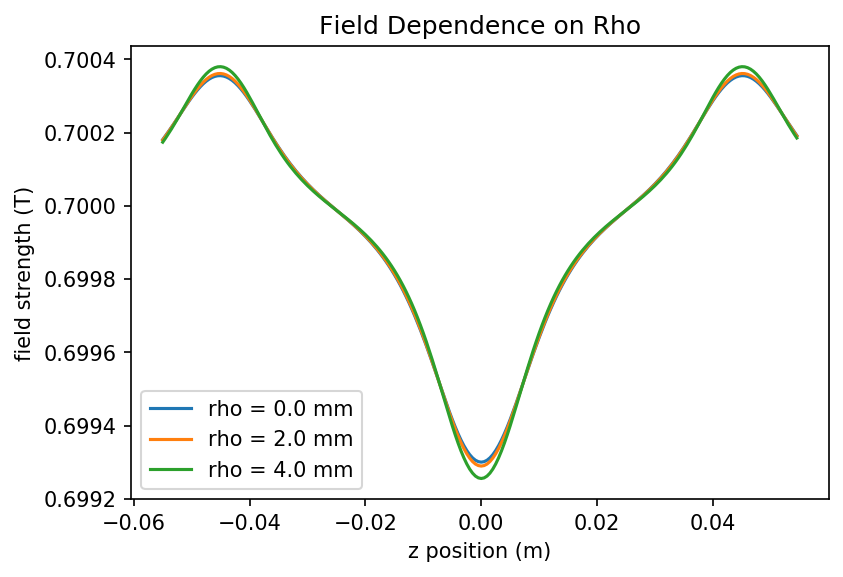

In [3]:
z_array = np.arange(-5.5e-2,5.5e-2,5e-4)
rho_field_array = np.arange(0,waveguide_radius-.001,2e-3)
field_strength_array = np.zeros((rho_field_array.shape[0],z_array.shape[0]))

for i,rho in enumerate(rho_field_array):
    for j,z in enumerate(z_array):
        field_strength_array[i][j] = trap_profile.field_strength_interp(rho,z)

fig1, ax1 = plt.subplots(figsize = (6,4))
    
for i, field_strength in enumerate(field_strength_array):
    
    ax1.plot(z_array,field_strength, label = 'rho = {} mm'.format(rho_field_array[i]*1000))
ax1.legend(loc='lower left')
ax1.set_xlabel('z position (m)')
ax1.set_ylabel('field strength (T)')
ax1.set_title('Field Dependence on Rho')
plt.show()


# Min Trapped Angle Dependence Rho

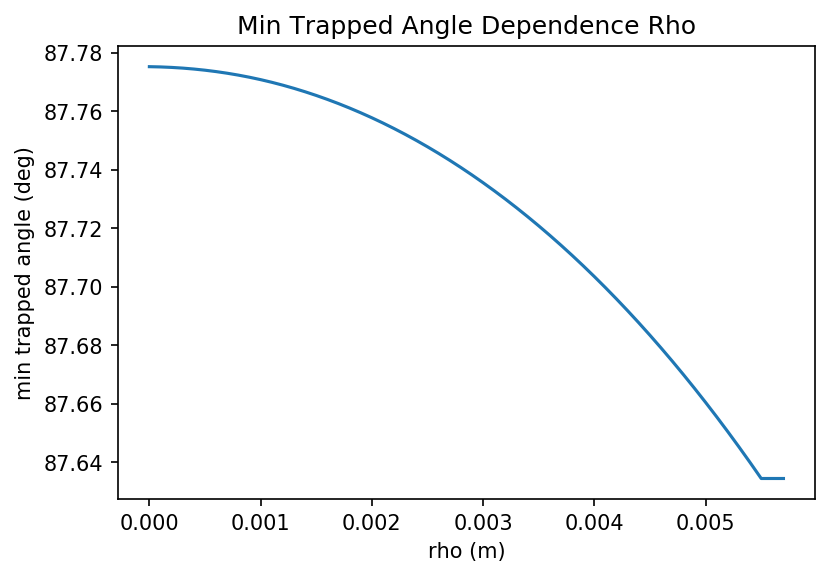

In [4]:
rho_array = np.arange(0,waveguide_radius,1e-4)
min_trapped_angle = np.zeros_like(rho_array)

for i,rho in enumerate(rho_array):
    min_trapped_angle[i] = sc_rho.min_theta(rho, 0, trap_profile)

fig1, ax1 = plt.subplots(figsize = (6,4))

ax1.plot(rho_array,min_trapped_angle)

ax1.set_xlabel('rho (m)')
ax1.set_ylabel('min trapped angle (deg)')
ax1.set_title('Min Trapped Angle Dependence Rho')
plt.show()

## Zmax vs Center Pitch Angle vs Rho

In [5]:
rho_array = np.arange(0,waveguide_radius-.001,2e-3)
center_pitch_angle_array = np.arange(88,90,.1)
zmax_array = np.zeros((rho_array.shape[0],center_pitch_angle_array.shape[0]))

for i,rho in enumerate(rho_array):
    for j,center_pitch_angle in enumerate(center_pitch_angle_array):
        zmax_array[i][j] = sc_rho.max_zpos(center_pitch_angle,rho, trap_profile,debug=False)

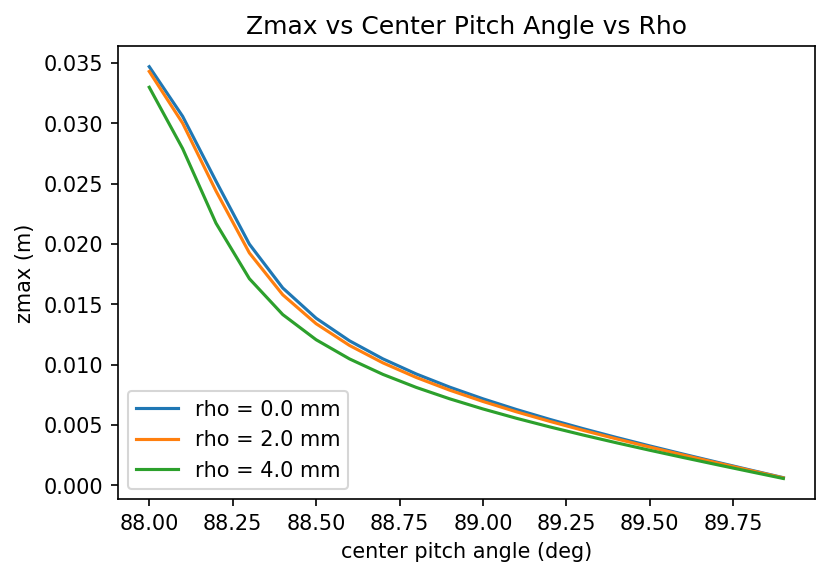

In [6]:
fig1, ax1 = plt.subplots(figsize = (6,4))
    
for i, zmax in enumerate(zmax_array):
    
    ax1.plot(center_pitch_angle_array,zmax, label = 'rho = {} mm'.format(rho_array[i]*1000))
ax1.legend(loc='lower left')
ax1.set_xlabel('center pitch angle (deg)')
ax1.set_ylabel('zmax (m)')
ax1.set_title('Zmax vs Center Pitch Angle vs Rho')
plt.show()

## Axial Freq vs Center Pitch Angle vs Rho

In [7]:
rho_array = np.arange(0,waveguide_radius-.001,2e-3)
center_pitch_angle_array = np.arange(88,90,.1)
axial_freq_array = np.zeros((rho_array.shape[0],center_pitch_angle_array.shape[0]))

for i,rho in enumerate(rho_array):
    for j,center_pitch_angle in enumerate(center_pitch_angle_array):
        axial_freq_array[i][j] = sc_rho.axial_freq(energy,center_pitch_angle,rho, trap_profile)

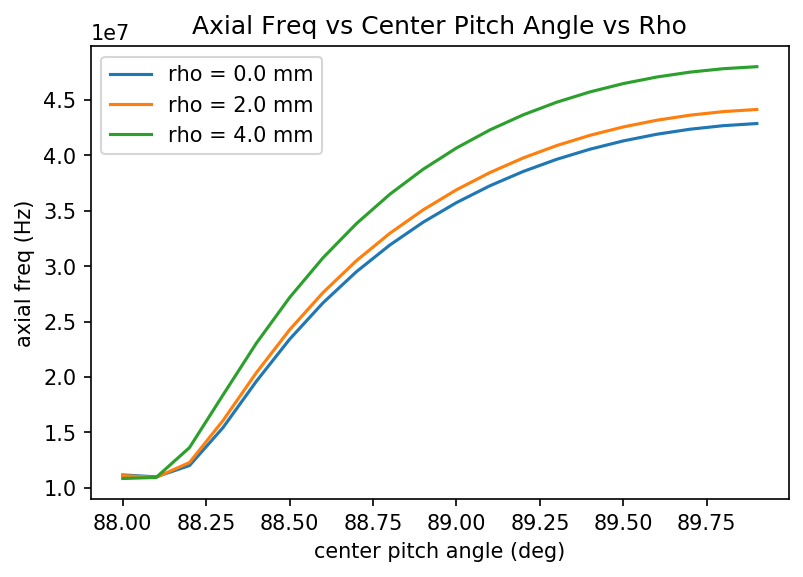

In [8]:
fig1, ax1 = plt.subplots(figsize = (6,4))
    
for i, axial_freq in enumerate(axial_freq_array):
    
    ax1.plot(center_pitch_angle_array, axial_freq, label = 'rho = {} mm'.format(rho_array[i]*1000))
ax1.legend(loc='upper left')
ax1.set_xlabel('center pitch angle (deg)')
ax1.set_ylabel('axial freq (Hz)')
ax1.set_title('Axial Freq vs Center Pitch Angle vs Rho')
plt.show()

## Avg Cycl Freq vs Center Pitch Angle vs Rho

In [9]:
rho_array = np.arange(0,waveguide_radius-.001,2e-3)
center_pitch_angle_array = np.arange(88,90,.1)
avg_cyc_freq_array = np.zeros((rho_array.shape[0],center_pitch_angle_array.shape[0]))

for i,rho in enumerate(rho_array):
    for j,center_pitch_angle in enumerate(center_pitch_angle_array):
        avg_cyc_freq_array[i][j] = sc_rho.avg_cyc_freq(energy, axial_freq_array[i][j], center_pitch_angle, rho, trap_profile)

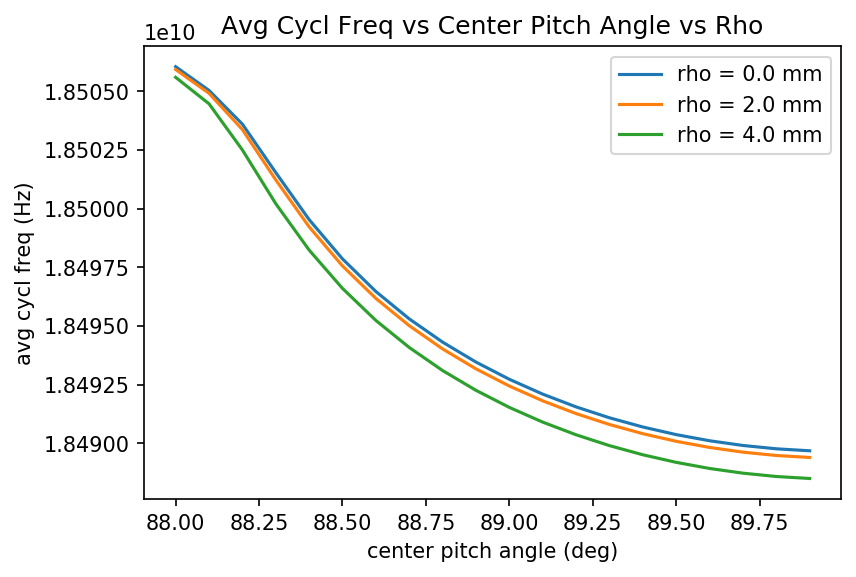

In [10]:
fig1, ax1 = plt.subplots(figsize = (6,4))
    
for i, avg_cyc_freq in enumerate(avg_cyc_freq_array):
    
    ax1.plot(center_pitch_angle_array, avg_cyc_freq, label = 'rho = {} mm'.format(rho_array[i]*1000))
ax1.legend(loc='upper right')
ax1.set_xlabel('center pitch angle (deg)')
ax1.set_ylabel('avg cycl freq (Hz)')
ax1.set_title('Avg Cycl Freq vs Center Pitch Angle vs Rho')
plt.show()

## t(z) vs z vs center pitch angle (@rho = 0): 


* Making better sense now that it's with jagged arrays.  

In [57]:
rho = 0.000
z_arrays = []
t_arrays = [] 

# zmax = sc_rho.max_zpos(center_pitch_angle,rho, trap_profile,debug=False)
min_pitch = sc_rho.min_theta(rho, 0, trap_profile)
center_pitch_angle_array = np.arange(min_pitch,90,.25)

for i, center_pitch_angle in enumerate(center_pitch_angle_array): 
    zmax = sc_rho.max_zpos(center_pitch_angle,rho, trap_profile,debug=False)
    z_array = np.arange(0,zmax,1e-4)
    t_array = np.zeros_like(z_array)
    
    for j,z in enumerate(z_array):
        t_array[j] = sc_rho.t(energy, z, center_pitch_angle, rho, trap_profile)
    z_arrays.append(z_array)
    t_arrays.append(t_array)

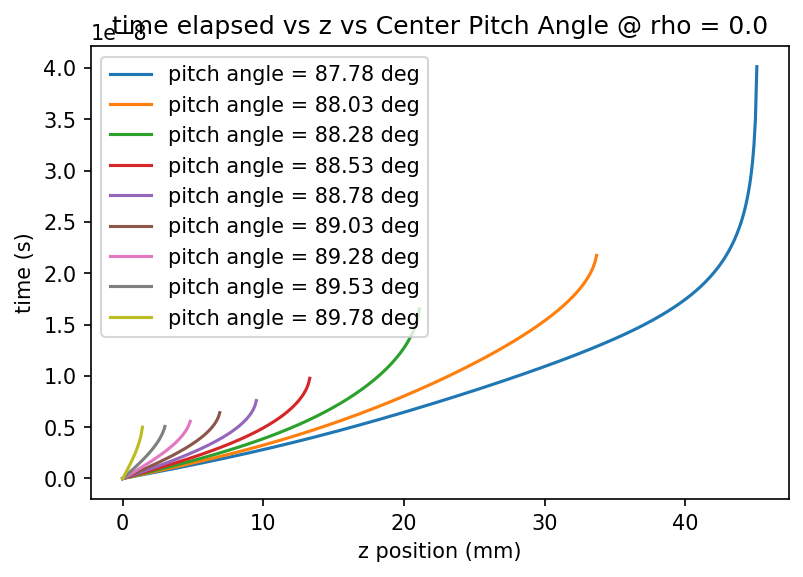

In [58]:
# print(z_arrays)
# print(t_array)
fig1, ax1 = plt.subplots(figsize = (6,4))
    
for i, (z,t)  in enumerate(zip(z_arrays,t_arrays)):
    ax1.plot(z*1000, t, label = 'pitch angle = {} deg'.format(np.around(center_pitch_angle_array[i],2)))
    
ax1.legend(loc='upper left')
ax1.set_xlabel('z position (mm)')
ax1.set_ylabel('time (s)')
ax1.set_title('time elapsed vs z vs Center Pitch Angle @ rho = {}'.format(rho))
plt.show()

# Need to now improve the speed of these functions. (Improving B-field strength method speed)

* I think the way to do this is to make the field reference a field map that get's written to a file and then create a 2D interpolation of the field that gets called each time you want the field value. First test to see how well this works before writing to a file and figuring out where this method should live. 

Mini Goals: 

* Have something that works faster at least partially working by our Friday check-in @ 2pm. 

Steps: 

* As a first step, time how long each call to the field takes. 
* Then get a very rough (not many points) interpolation working and see how long that takes to call. 
* See if you can get away with not needing to write a file to disk. This makes it much less user freindly. If the trap_profile takes some time to load then so be it. 

In [13]:
# Standard:
import os
import json
import math
import pandas as pd
pd.set_option('display.max_rows', 1000)
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d

# Supress pd warnings: 
pd.options.mode.chained_assignment = None

# spec_tools library
import spec_tools.spec_calc.spec_calc_with_rho_dependence as sc_rho
import spec_tools.spec_calc.spec_calc as sc
import spec_tools.spec_calc.power_calc as pc
from spec_tools.load_default_field_profiles import load_he6_trap

%matplotlib inline
# mpld3.disable_notebook()
plt.rcParams.update({'font.size': 10})
plt.rcParams['figure.dpi'] = 150

In [122]:
## Testing the new sc with rho dependence 

# define trap
main_field = 7
trap_strength = 10e-3
trap_profile = load_he6_trap(main_field, trap_strength)

waveguide_radius = 0.578e-2 # (m)
trap_zmax = 5.5e-2 # (m)

grid_edge_length = 5e-4 # (m)

rho_array = np.arange(0, waveguide_radius, grid_edge_length)
z_array = np.arange(-trap_zmax,trap_zmax,grid_edge_length)

map_array = np.zeros((z_array.shape[0],rho_array.shape[0]))
print(rho_array.shape)
print(z_array.shape)
print(map_array.shape)
print(map_array.size)

Optimization terminated successfully.
         Current function value: -7.035540
         Iterations: 42
         Function evaluations: 91
Trap width: (-0.045156887531280526,0.045156887531280526)
Maximum Field: 7.035540490574711
(12,)
(220,)
(220, 12)
2640


In [123]:
import time

B = lambda rho,z : trap_profile.field_strength(rho, z)
start = time.process_time()
# your code here    

for i,z in enumerate(z_array):
    for j,rho in enumerate(rho_array):
        map_array[i][j] = B(rho,z)
        
tot_time = time.process_time() - start 
time_per_call_original = tot_time/map_array.size
print("time per call (originally) = ", time_per_call_original)
# print(map_array)

time per call (originally) =  0.0422290685685606


In [124]:
# Now try the interpoloation: 

# Start with 1d interp:
# B_rhozero_interp1d = interp1d(z_array, map_array[:0], kind='cubic', fill_value = 'extrapolate')

# Now do 2d interp: 
B_interp2d = interp2d(rho_array,z_array, map_array, kind='cubic') # the 2d interpolation does automatic extrapolation


In [125]:
print(B_interp2d(.001, 0.005)[0])
print(B(0.001,0.005))

6.941547770153707
6.941547770153707


## how fast is it? 

In [128]:
# make a grid with half the edge length: (for meaninful comparison)
test_grid_num = 10

rho_array = np.random.uniform(0, waveguide_radius, test_grid_num)
z_array = np.random.uniform(-trap_zmax,trap_zmax,test_grid_num)

map_array_original = np.zeros((z_array.shape[0],rho_array.shape[0]))
map_array_interp2d = np.zeros_like(map_array_original)

In [129]:
# Retest the original with fewer points: 

start = time.process_time()
# your code here    

for i,z in enumerate(z_array):
    for j,rho in enumerate(rho_array):
        map_array_original[i][j] = B(rho,z)
        
tot_time = time.process_time() - start 
time_per_call_original = tot_time/map_array_original.size
print("time per call = ", time_per_call_original)

time per call =  0.04844266732000051


In [130]:
# Test the Interp2d: 

start = time.process_time()
# your code here    

for i,z in enumerate(z_array):
    for j,rho in enumerate(rho_array):
        map_array_interp2d[i][j] = B_interp2d(rho,z)
        
tot_time = time.process_time() - start 
time_per_call_interp2d = tot_time/map_array_interp2d.size
print("time per call = ", time_per_call_interp2d)

print("improvement factor", time_per_call_original/time_per_call_interp2d)
        

time per call =  0.0002394500600007632
improvement factor 202.3080191328668


## how good is it? 

In [131]:
absolute_tolerance = 1e-4
allclose = np.allclose(map_array_interp2d-map_array_original, np.zeros_like(map_array_original), atol=absolute_tolerance)
print("All field values within {} Tesla: {}".format(absolute_tolerance, allclose) )

All field values within 0.0001 Tesla: True


In [132]:
print("Relative Difference Mean: ",((map_array_interp2d-map_array_original)/map_array_original).mean())
print("Relative Difference Std: ",((map_array_interp2d-map_array_original)/map_array_original).std())

Relative Difference Mean:  4.683071600495109e-10
Relative Difference Std:  9.732442697324441e-09


## Conclusions: 

Initial Tests: 
* With a grid length edge of 5e-4 we get relative agreement between the field strength and the interpolated field of less than 1 ppm.
    * I've verified this at .7 T and 7 T. As well as 1e-3 and 10e-3 relative strengths. It actually works even better for deeper traps. 

* The original function took roughly .05 s per call. The new function takes roughly 5e-5 s (10^3 less time per call). 
    * So you need to do a 2640 x .05 = 2 mins calculation up front. But ideally it saves you a lot of time. 

Implementing it within the spec tools framework: 

* Redo all above plots and make sure they are fast. 
* Going to have the field 
* A python note: "class Trap_profile(field_profile)" means that the trap_profile class inherits from the field_profile class! Should read more about. 
* Ok going to have an initialize_field_strength_fast() that gets called in the init and then a funcion field_strength_fast() that can be called. 

In [1]:
from spec_tools.load_default_field_profiles import load_he6_trap

In [2]:
# define trap
main_field = 7
trap_strength = 10e-3
trap_profile = load_he6_trap(main_field, trap_strength)


(6,)
(110,)
(110, 6)
660
time to initialize field_strength_interp =  23.380120835
(6,)
(110,)
(110, 6)
660
time to initialize field_strength_interp =  23.645222981999996
Optimization terminated successfully.
         Current function value: -7.035540
         Iterations: 42
         Function evaluations: 91
Trap width: (-0.045156887531280526,0.045156887531280526)
Maximum Field: 7.035540490574711


In [3]:
# print(trap_profile.test_func())
print(trap_profile.field_strength(0,0))
print(trap_profile.field_strength_interp(0,0))

6.930000001496451
6.930000001496451


In [3]:
energy = 30e3

center_pitch_angles = np.arange(88,89.9,.5)
rho_array = np.arange(0,.005,.002)
avg_cyc_freqs = np.zeros((rho_array.shape[0],center_pitch_angles.shape[0]))

for j,rho in enumerate(rho_array):
    for i,pitch_angle in enumerate(center_pitch_angles):
    
        avg_cyc_freqs[j][i] = sc_alt.avg_cyc_freq(energy, rho, pitch_angle, trap_profile)
        print(i,j)
#     field_strength_2[i] = trap_profile.field_strength(.005,z)
  

units of time elapsed: 20.0
Estimate of axial_freq = 78539816.33974482 Hz 
0 0
units of time elapsed: 8.0
Estimate of axial_freq = 196349540.84936205 Hz 
1 0
units of time elapsed: 5.0
Estimate of axial_freq = 314159265.3589793 Hz 
2 0
units of time elapsed: 4.0
Estimate of axial_freq = 392699081.6987241 Hz 
3 0
units of time elapsed: 20.0
Estimate of axial_freq = 78539816.33974482 Hz 
0 1
units of time elapsed: 8.0
Estimate of axial_freq = 196349540.84936205 Hz 
1 1
units of time elapsed: 5.0
Estimate of axial_freq = 314159265.3589793 Hz 
2 1
units of time elapsed: 4.0
Estimate of axial_freq = 392699081.6987241 Hz 
3 1
units of time elapsed: 20.0
Estimate of axial_freq = 78539816.33974482 Hz 
0 2
units of time elapsed: 6.999999999999999
Estimate of axial_freq = 224399475.2564138 Hz 
1 2
units of time elapsed: 4.0
Estimate of axial_freq = 392699081.6987241 Hz 
2 2
units of time elapsed: 4.0
Estimate of axial_freq = 392699081.6987241 Hz 
3 2


[[2.64362405e+10 2.64237933e+10 2.64172037e+10 2.64144875e+10]
 [2.64360389e+10 2.64236263e+10 2.64169273e+10 2.64141134e+10]
 [2.64354190e+10 2.64221412e+10 2.64151756e+10 2.64129328e+10]]


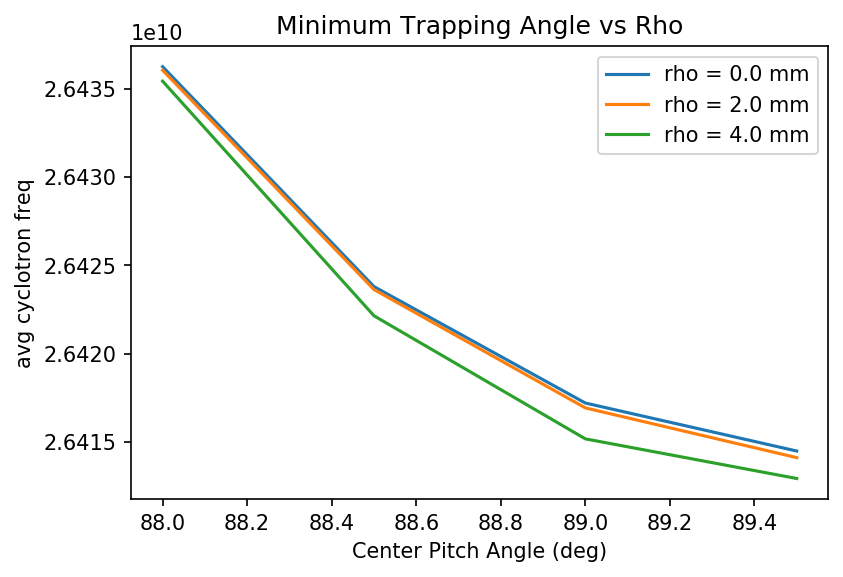

In [4]:
print(avg_cyc_freqs)
fig1, ax1 = plt.subplots(figsize = (6,4))

for i,freq_array in enumerate(avg_cyc_freqs):
    
    ax1.plot(center_pitch_angles,freq_array, label = 'rho = {} mm'.format(rho_array[i]*1000))
# ax1.plot(z_array, field_strength_2, label = 'rho = 5 mm')
ax1.legend(loc='upper right')
ax1.set_ylabel('avg cyclotron freq')
ax1.set_xlabel('Center Pitch Angle (deg)')
ax1.set_title('Minimum Trapping Angle vs Rho')
plt.show()

## Looking into best way to get axial_freq. 

* For now it seems like finding axial_freq and assuming harmonic motion is the easiest and best way forward.



In [3]:
## Testing the new lookup table method. 

# Define trap
main_field = 1
trap_strength = 1e-3
trap_profile = load_he6_trap(main_field, trap_strength)

Optimization terminated successfully.
         Current function value: -1.000508
         Iterations: 42
         Function evaluations: 97
Trap width: (-0.04515689086914063,0.04515689086914063)
Maximum Field: 1.0005077212939244


In [3]:


# print(sc.axial_freq(energy, center_pitch_angle,trap_profile))

min_trapped_theta = sc.min_theta(0,trap_profile)
# print(min_trapped_theta)
center_pitch_angles = np.arange(min_trapped_theta,90,.2)
rho = 0
energy = 30e3
trap_strength = 10**-3
axial_freq_P_over_E = np.zeros_like(center_pitch_angles)
axial_freq_sec = np.zeros_like(center_pitch_angles)
axial_freq_sec_alt = np.zeros_like(center_pitch_angles)

for i, center_pitch_angle in enumerate(center_pitch_angles): 

    axial_freq_P_over_E[i] = sc.axial_freq_P_over_E(energy, center_pitch_angle, trap_profile, trap_strength)
    axial_freq_sec[i] = sc.axial_freq_new(energy, center_pitch_angle, trap_profile)
    axial_freq_sec_alt[i] = sc_alt.axial_freq_sec(energy, center_pitch_angle, rho, trap_profile)

Calculating axial frequency using P_over_E lookup_table...
The lookup_table directory exists.
File exists.
Calculating axial frequency using P_over_E lookup_table...
The lookup_table directory exists.
File exists.


/home/drew/home/drew/Products/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadrature.py:802: AccuracyWarning: divmax (10) exceeded. Latest difference = 6.838761e+01
  AccuracyWarning)
/home/drew/He6CRES/SimulationDev/spec_tools/spec_calc/spec_calc_with_rho_dependence.py:359: RuntimeWarning: divide by zero encountered in double_scalars
  sec_theta = lambda z : (1-B(z)/Bmax)**(-.5)  # secant of theta as function of z. Use conserved mu to derive.
/home/drew/home/drew/Products/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadrature.py:802: AccuracyWarning: divmax (10) exceeded. Latest difference = 1.624190e-01
  AccuracyWarning)


Calculating axial frequency using P_over_E lookup_table...
The lookup_table directory exists.
File exists.


/home/drew/home/drew/Products/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadrature.py:802: AccuracyWarning: divmax (10) exceeded. Latest difference = 1.607724e-01
  AccuracyWarning)


Calculating axial frequency using P_over_E lookup_table...
The lookup_table directory exists.
File exists.


/home/drew/home/drew/Products/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadrature.py:802: AccuracyWarning: divmax (10) exceeded. Latest difference = 8.061294e-02
  AccuracyWarning)


Calculating axial frequency using P_over_E lookup_table...
The lookup_table directory exists.
File exists.


/home/drew/home/drew/Products/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadrature.py:802: AccuracyWarning: divmax (10) exceeded. Latest difference = 4.457660e-02
  AccuracyWarning)


Calculating axial frequency using P_over_E lookup_table...
The lookup_table directory exists.
File exists.


/home/drew/home/drew/Products/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadrature.py:802: AccuracyWarning: divmax (10) exceeded. Latest difference = 2.986620e-02
  AccuracyWarning)


Calculating axial frequency using P_over_E lookup_table...
The lookup_table directory exists.
File exists.


/home/drew/home/drew/Products/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadrature.py:802: AccuracyWarning: divmax (10) exceeded. Latest difference = 2.189506e-02
  AccuracyWarning)


Calculating axial frequency using P_over_E lookup_table...
The lookup_table directory exists.
File exists.


/home/drew/home/drew/Products/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadrature.py:802: AccuracyWarning: divmax (10) exceeded. Latest difference = 1.666531e-02
  AccuracyWarning)


Calculating axial frequency using P_over_E lookup_table...
The lookup_table directory exists.
File exists.


/home/drew/home/drew/Products/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadrature.py:802: AccuracyWarning: divmax (10) exceeded. Latest difference = 1.267240e-02
  AccuracyWarning)


Calculating axial frequency using P_over_E lookup_table...
The lookup_table directory exists.
File exists.


/home/drew/home/drew/Products/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadrature.py:802: AccuracyWarning: divmax (10) exceeded. Latest difference = 9.144303e-03
  AccuracyWarning)


Calculating axial frequency using P_over_E lookup_table...
The lookup_table directory exists.
File exists.


/home/drew/home/drew/Products/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadrature.py:802: AccuracyWarning: divmax (10) exceeded. Latest difference = 5.440496e-03
  AccuracyWarning)


Calculating axial frequency using P_over_E lookup_table...
The lookup_table directory exists.
File exists.


/home/drew/home/drew/Products/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadrature.py:802: AccuracyWarning: divmax (10) exceeded. Latest difference = 3.736494e-04
  AccuracyWarning)


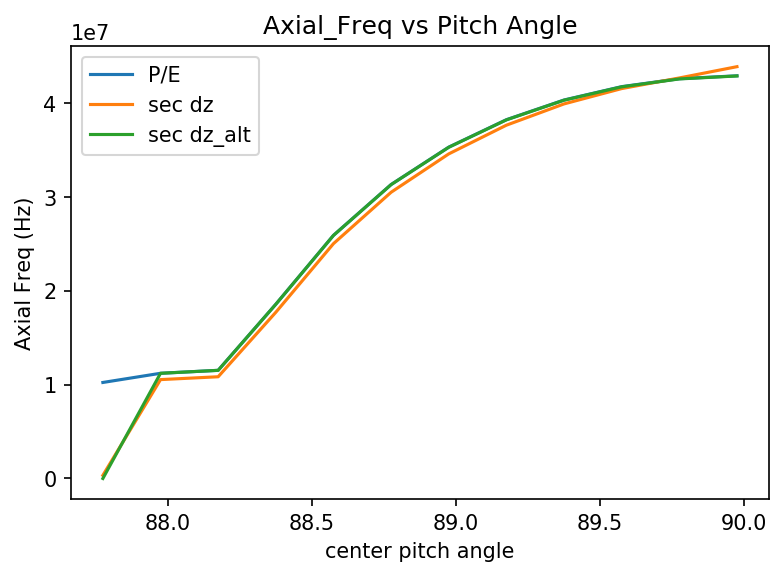

In [4]:
fig1, ax1 = plt.subplots(figsize = (6,4))


ax1.plot(center_pitch_angles, axial_freq_P_over_E, label = "P/E")
ax1.plot(center_pitch_angles, axial_freq_sec, label = "sec dz")    
ax1.plot(center_pitch_angles, axial_freq_sec_alt, label = "sec dz_alt") 

ax1.legend(loc='upper left')
ax1.set_xlabel('center pitch angle')
ax1.set_ylabel('Axial Freq (Hz)')
ax1.set_title('Axial_Freq vs Pitch Angle')
plt.show()

In [3]:
# Recreating Axial_Freq Fig 3.3b:

min_trapped_theta = sc.min_theta(0,trap_profile)
# print(min_trapped_theta)
center_pitch_angles = np.arange(88,90,.25)

energy = 30e3

rho = 0 
avg_cycl_freqs = np.zeros_like(center_pitch_angles)

for i, center_pitch_angle in enumerate(center_pitch_angles):
    
    axial_freq =  sc_alt.axial_freq_sec(energy, center_pitch_angle, rho, trap_profile)
    print(axial_freq)
    avg_cycl_freqs[i] = sc_alt.avg_cyc_freq(energy, axial_freq, rho, center_pitch_angle, trap_profile)

11155787.334122116
13469954.648794323
23399528.89872555
30736630.127430376
35727307.664335884
39108180.15399889
41295892.944647156
42526642.3523035


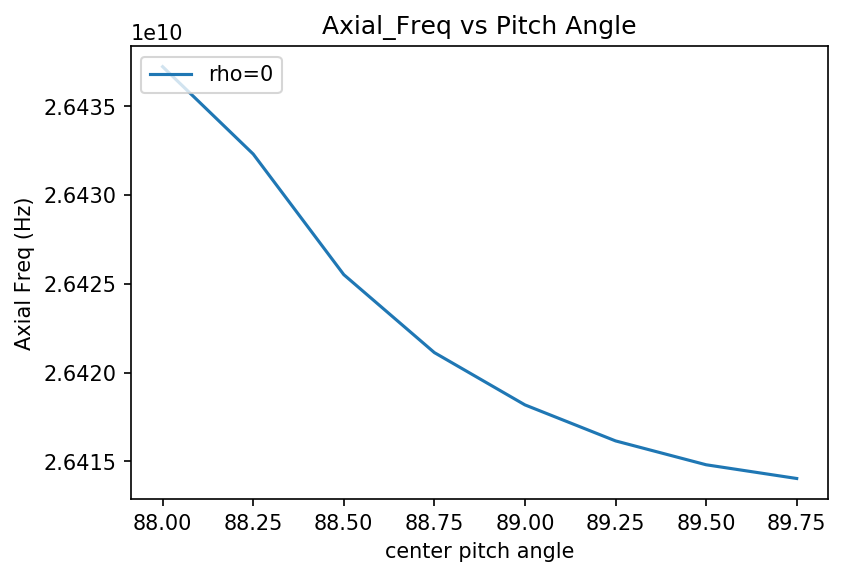

In [4]:
fig1, ax1 = plt.subplots(figsize = (6,4))


ax1.plot(center_pitch_angles, avg_cycl_freqs, label = "rho=0")

ax1.legend(loc='upper left')
ax1.set_xlabel('center pitch angle')
ax1.set_ylabel('Axial Freq (Hz)')
ax1.set_title('Axial_Freq vs Pitch Angle')
plt.show()

In [7]:
# Recreating Axial_Freq Fig 3.3b:
zmax  = sc.max_zpos(88,trap_profile)
# print(min_trapped_theta)
zs = np.arange(0,zmax,.00025)
# print(zs)
energy = 30e3
center_pitch_angle = 88
rho = 0 
ts = np.zeros_like(zs)

for i, z in enumerate(zs):
    
    t_z =  sc_alt.t_sec(energy, z, center_pitch_angle, rho, trap_profile)
   
    ts[i] = t_z
print(1/(4*sc_alt.t_sec(energy, zmax, center_pitch_angle, rho, trap_profile)))
print(sc_alt.axial_freq_sec(energy, center_pitch_angle, rho, trap_profile))

ERROR: zpos larger than zmax.
11155787.336398296
11155787.334122116


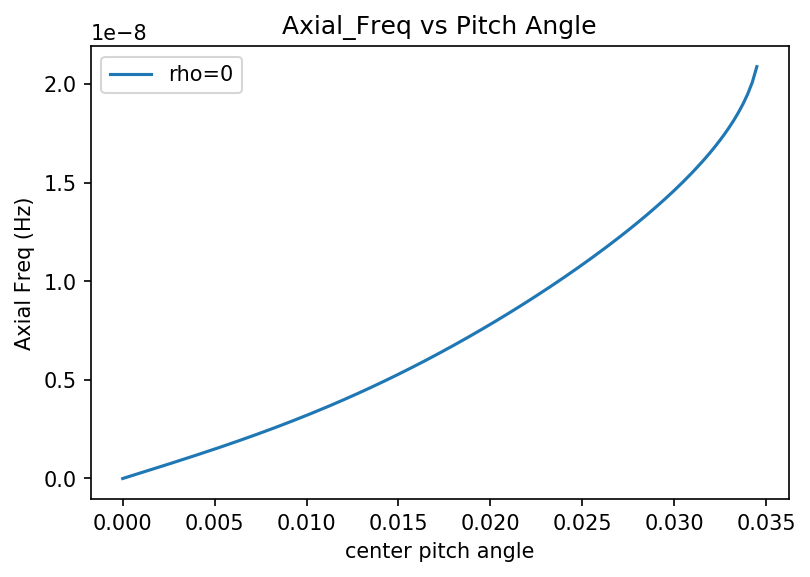

In [4]:
fig1, ax1 = plt.subplots(figsize = (6,4))


ax1.plot(zs, ts, label = "rho=0")

ax1.legend(loc='upper left')
ax1.set_xlabel('center pitch angle')
ax1.set_ylabel('Axial Freq (Hz)')
ax1.set_title('Axial_Freq vs Pitch Angle')
plt.show()

# OLD (OR NOW REFLECTED IN sc)

# Using Ali's Thesis Eq. 3.23 to create a new axial_freq formula: 

Summarizing my findings thus far:

* The formulas (Eq 3.23 and 3.10) listed in Ali's thesis don't account for relativity. They use the classical relationships between momentum and energy. This causes issues. 

In [7]:
# Standard:
import os
import json
import math
import pandas as pd
pd.set_option('display.max_rows', 1000)
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as special
# Supress pd warnings: 
pd.options.mode.chained_assignment = None

# Kris's Library
import spec_tools.spec_calc.spec_calc as sc
import spec_tools.spec_calc.power_calc as pc
from spec_tools.load_default_field_profiles import load_he6_trap



In [20]:
## Testing Ali's Thesis Eq. 3.23 method (Without alterations): 

# fixed parameters: 
me = 5.10998950e5 # Electron rest mass, in eV
m = 9.1093837015e-31 # Electron rest mass, in kg
c = 299792458 # Speed of light in vacuum, in m/s
JeV = 6.241509074e18 # Joule-ev conversion

# Define trap and other parameters: 
main_field = .7
trap_strength = 3e-3
trap_profile = load_he6_trap(main_field, trap_strength)

center_pitch_angle = 88.5
KE = 60e4

Optimization terminated successfully.
         Current function value: -0.701066
         Iterations: 42
         Function evaluations: 92
Trap width: (-0.04515688705444337,0.04515688705444337)
Maximum Field: 0.7010662147172413


In [21]:
# Step 1: Find zmax
zmax = sc.max_zpos(center_pitch_angle,trap_profile,debug=True)
print("zmax: ",zmax)

Final field greater than max allowed field by:  7.692624315325247e-12
Bmax reached:  0.6983785518192905
zlength:  0.005996618928590863
zmax:  0.005996618928590863


In [22]:
# Step 2: Find mu and verify it's a constant of the motion: 

Bmax = trap_profile.field_strength(0,zmax)
Bmin = trap_profile.field_strength(0,0)
# print(Bmax, Bmin)

p_squared = lambda KE : (((KE/JeV) + m*c**2)/c)**2 - m**2*c**2 

mu_check = 1/2*p_squared(KE)/m*(np.sin(center_pitch_angle*math.pi/180)**2/Bmin)
mu = 1/2*p_squared(KE)/m*(1/Bmax)

print("consistency check (is mu actually a constant of the motion?): ",mu_check, mu, "\n")
print("This is over the kinetic energy. This is the root of the problem: ", mu*Bmin*JeV, "eV", "\n")
print(mu*Bmax*JeV, mu*Bmin*JeV, "\n")

consistency check (is mu actually a constant of the motion?):  2.1845955025863978e-13 2.1845955025623343e-13 

This is over the kinetic energy. This is the root of the problem:  951598.699462606 eV 

952251.2130693009 951598.699462606 



It makes sense that this doesn't work because p^2/2m doesn't hold relativistically. You can't just solve this with a gamma thrown in or something 

## Implimenting 2 changes: 

1. mu = KE sin^2(theta)/B
    * This forces the energy lost to the magnetic moment to make sense.     
2. Also need to correct for using the relationship 1/2mv^2 = KE in the formula. 
    * Here I use E_tot = KE + mc^2 = gamma m c^2

In [23]:
# fixing the formula for v_z and accounting for relativity: 

# First just creating a formula for v as a function of KE: 
v = lambda KE: c*(np.sqrt(1-(KE/me+1)**(-2))) # KE in eV


mu = KE/JeV*(1/Bmax)
v_z = lambda z: c*(np.sqrt(1-((KE-mu*trap_profile.field_strength(0,z)*JeV)/me+1)**(-2))) # KE in eV
integrand = lambda z: (v_z(z))**-1 # KE in eV

axial_freq_ali = (2/math.pi*integrate.quad(integrand, 0, zmax)[0])**-1

axial_freq_kris = sc.axial_freq(KE, center_pitch_angle, trap_profile)

Calculating axial frequency...


In [24]:
print(axial_freq_ali,  axial_freq_kris)
print(axial_freq_ali/axial_freq_kris)

1937373276.684001 177304964.53900144
10.926785280498114


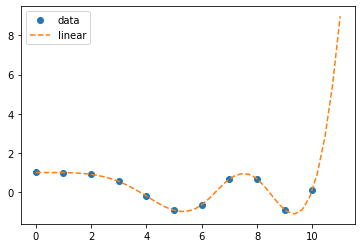

In [7]:
from scipy.interpolate import interp1d
x = np.linspace(0, 10, num=11, endpoint=True)
y = np.cos(-x**2/9.0)
f = interp1d(x, y)
f2 = interp1d(x, y, kind='cubic', fill_value="extrapolate")
xnew = np.linspace(0, 11, num=41, endpoint=True)
import matplotlib.pyplot as plt
plt.plot(x, y, 'o', xnew, f2(xnew), '--')
plt.legend(['data', 'linear', 'cubic'], loc='best')
plt.show()

In [5]:
from scipy.interpolate import interp1d
x = np.array(A[1]["center_theta_array"])
y = np.array(A[1]["{}".format(trap_strength)])
print(x,y)
f = interp1d(x, y, fill_value = 'extrapolate')
f2 = interp1d(x, y, kind='cubic', fill_value = 'extrapolate')
xnew = np.linspace(x[0], 90, num=41, endpoint=True)

[88.27524558 88.37524558 88.47524558 88.57524558 88.67524558 88.77524558
 88.87524558 88.97524558 89.07524558 89.17524558 89.27524558 89.37524558
 89.47524558 89.57524558 89.67524558 89.77524558 89.87524558] [14415503.23945299 18579459.14451648 22514165.91319549 25925783.81422358
 28845843.19861171 31346193.63170574 33491098.735775   35332143.34674267
 36910229.89167339 38257537.50003615 39399737.12495223 40357535.47830825
 41147183.47529065 41781845.28684119 42271715.82585599 42624219.76366192
 42844681.17560122]


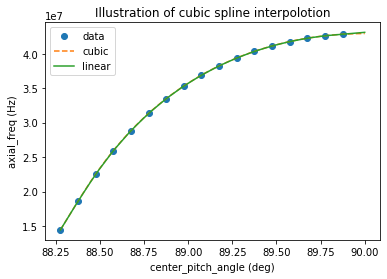

In [6]:
import matplotlib.pyplot as plt
plt.plot(x, y,  'o', xnew, f2(xnew), '--')
plt.plot(xnew, f(xnew),  '-')
plt.title("Illustration of cubic spline interpolotion")
plt.ylabel('axial_freq (Hz)', fontsize = 10)
plt.xlabel('center_pitch_angle (deg)', fontsize = 10)
plt.legend(['data',  'cubic','linear'], loc='best')
plt.show()

In [8]:
# f2(center_pitch_angle)
energy = 30.0e4
print(sc.axial_freq(energy, 89.5, trap_profile))
print(sc.axial_freq_P_over_E(energy, 89.5, trap_profile, trap_strength = .001)[0])

Calculating axial frequency...
97800658.78523982
Calculating axial frequency using P_over_E lookup_table...
The lookup_table directory exists.
File exists.
center_theta_array:  [88.27524558 88.37524558 88.47524558 88.57524558 88.67524558 88.77524558
 88.87524558 88.97524558 89.07524558 89.17524558 89.27524558 89.37524558
 89.47524558 89.57524558 89.67524558 89.77524558 89.87524558]
[88.27524558 88.37524558 88.47524558 88.57524558 88.67524558 88.77524558
 88.87524558 88.97524558 89.07524558 89.17524558 89.27524558 89.37524558
 89.47524558 89.57524558 89.67524558 89.77524558 89.87524558] [14415503.23945299 18579459.14451648 22514165.91319549 25925783.81422358
 28845843.19861171 31346193.63170574 33491098.735775   35332143.34674267
 36910229.89167339 38257537.50003615 39399737.12495223 40357535.47830825
 41147183.47529065 41781845.28684119 42271715.82585599 42624219.76366192
 42844681.17560122]
97707151.29608703


In [11]:
# f2(center_pitch_angle)
print(sc.axial_freq(energy, 89.99999, trap_profile))

Calculating axial frequency...
ends with pitch angle 90: 89.99999  zpos:  6.344264660956159e-08
133800743.93165213


In [14]:
np.arange(90,np87.75,.5)

array([], dtype=float64)

In [10]:
# Define trap 1: 
main_field_1 = 70
trap_strength_1 = 1e-3
trap_profile_1 = load_he6_trap(main_field_1, trap_strength_1)

# Define trap 2: 
main_field_2 = 2
trap_strength_2 = 1e-3
trap_profile_2 = load_he6_trap(main_field_2, trap_strength_2)

Optimization terminated successfully.
         Current function value: -70.035540
         Iterations: 42
         Function evaluations: 97
Trap width: (-0.04515689086914063,0.04515689086914063)
Maximum Field: 70.0355404905747
Optimization terminated successfully.
         Current function value: -2.001015
         Iterations: 42
         Function evaluations: 97
Trap width: (-0.04515689086914063,0.04515689086914063)
Maximum Field: 2.001015442587849


In [11]:
center_pitch_angle = 88
energy_1 = 18e5

min_theta_1 = sc.min_theta(0,trap_profile_1)
min_theta_2 = sc.min_theta(0,trap_profile_2)

print(min_theta_1,min_theta_2)

87.7752455776121 87.7752455776121


In [4]:
energy_1_axial_freq = sc.axial_freq(energy_1, center_pitch_angle, trap_profile_1)


energy_2 = energy_1


energy_2_axial_freq = sc.axial_freq(energy_2, center_pitch_angle,trap_profile_2)

Optimization terminated successfully.
         Current function value: -70.035540
         Iterations: 42
         Function evaluations: 97
Trap width: (-0.04515689086914063,0.04515689086914063)
Maximum Field: 70.0355404905747
Calculating axial frequency...
Optimization terminated successfully.
         Current function value: -2.001026
         Iterations: 42
         Function evaluations: 97
Trap width: (-0.04515689086914063,0.04515689086914063)
Maximum Field: 2.001025597013727
Calculating axial frequency...


In [30]:
## First see if the scaling goes as p/E: 

me = 5.10998950e5 # Electron rest mass, in eV
m = 9.1093837015e-31 # Electron rest mass, in kg
c = 299792458 # Speed of light in vacuum, in m/s
JeV = 6.241509074e18 # Joule-ev conversion

p = lambda E : np.sqrt(E**2 - (me)**2)
print(p(17.8e3+me))


E_1 = energy_1 + me
p_over_E_1 = p(E_1)/E_1

E_2 = energy_2 + me
p_over_E_2 = p(E_2)/E_2

print(p_over_E_1/p_over_E_2)
print(energy_1_axial_freq/energy_2_axial_freq)

print(energy_1_axial_freq*p_over_E_2/p_over_E_1)
print(energy_2_axial_freq)

136045.5902262178
0.9789122656449835
0.9763505852679877
33866309.545056246
33955165.59933825


In [15]:
# Define trap
main_field = .8
trap_strength = 1.0e-3
trap_profile = load_he6_trap(main_field, trap_strength)

energy = 36e3
center_pitch_angle = 89

method_1_axial_freq = sc.axial_freq(energy, center_pitch_angle,trap_profile)
method_2_axial_freq = sc.axial_freq_new(energy, center_pitch_angle,trap_profile)

print(method_1_axial_freq)
print(method_2_axial_freq)

Optimization terminated successfully.
         Current function value: -0.800406
         Iterations: 42
         Function evaluations: 95
Trap width: (-0.04515688705444337,0.04515688705444337)
Maximum Field: 0.8004061770351396
Calculating axial frequency...
38840502.25430023
38069783.37262035


In [49]:
# load trapping field 
main_field = 1
trap_strength = 1.0e-3
trap_profile = load_he6_trap(main_field, trap_strength)
field_strength = lambda r,z : trap_profile.field_values((r,0,z))[2]

# make list of radii 
r = np.arange(0,.01,.001)
field_strengths = []

# fill in field values as a function of radii for z = 0
z = 0 
for radius in r: 
    field_strengths.append(field_strength(radius,z))
field_strengths = np.array(field_strengths)  

Optimization terminated successfully.
         Current function value: -1.000508
         Iterations: 42
         Function evaluations: 97
Trap width: (-0.04515689086914063,0.04515689086914063)
Maximum Field: 1.0005077212939244


In [51]:
trap_profile.trap_strength

AttributeError: 'Trap_profile' object has no attribute 'trap_strength'

In [50]:
%matplotlib qt


plt.figure(1)
# plt.hist(df["segment_length"], bins = 100)

plt.ylabel('B (T)', fontsize = 10)
plt.xlabel('Rho (m)', fontsize = 10)
plt.title("Field Strength vs Rho")

plt.plot(r, field_strengths)
plt.show()

# Old Stuff (Clean later)

In [2]:
# Example Code: 

from spec_tools.spec_fitters.he6_random_beta import He6_random_beta 

test = He6_random_beta(b=0, max_error_diff = 1000)

In [24]:
# Let's explore the object: 
beta = test.generate_random_beta()

Calculating random energy...


In [29]:
# May be nice to have this be a dictionary so you know what you're looking at. Though changing things now may cause some issues. 
print(beta)
print(test.b)
print(test.max_error_diff)

(2681372.2835636097, [0.004961943821931623, 103.33177601612816, -0.0018718414904303647], [137.74684527091475, 270.2198864136177])
0
1000


In [26]:
test.b

0

In [28]:
test.max_error_diff


1000

Optimization terminated successfully.
         Current function value: -0.689350
         Iterations: 42
         Function evaluations: 95
Trap width: (-0.04515688705444337,0.04515688705444337)
Maximum Field: 0.6893498199715139



Directory 'power_data/power_data_test' does not exist
Do you want to create it?(y/n) y


/home/drew/He6CRES/SimulationDev/spec_tools/analysis_functions/sideband_power_calc.py:259: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Directory 'power_data/power_data_test' created
Running simulation 1/10...
Generated trapped beta...


Press ENTER to continue... 


Calculating power in sidebands...
Sum of sideband power amplitudes: 0.9978654003577785


/home/drew/He6CRES/SimulationDev/spec_tools/analysis_functions/sideband_power_calc.py:345: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Press ENTER to continue... 


/home/drew/He6CRES/SimulationDev/spec_tools/analysis_functions/sideband_power_calc.py:259: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Simulation saved as power_simulation_1.json

Running simulation 2/10...
Generated trapped beta...


Press ENTER to continue... 


Calculating power in sidebands...
Sum of sideband power amplitudes: 0.9999999999984094


/home/drew/He6CRES/SimulationDev/spec_tools/analysis_functions/sideband_power_calc.py:345: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


KeyboardInterrupt: 

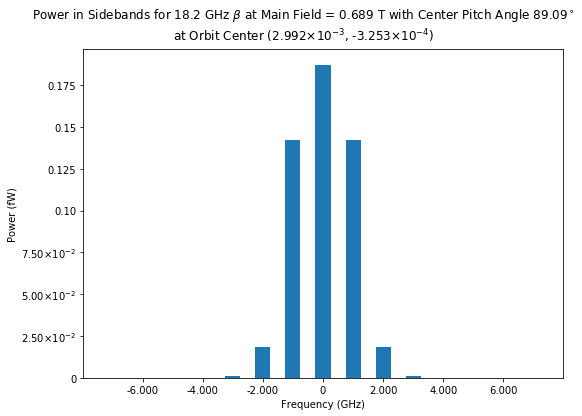

In [33]:
% run run_sideband_power.py

In [23]:
from spec_tools.spec_fitters.he6_random_beta import He6_random_beta 



# Configurable Parameters (to go into a config file)
events_to_simulate = 1

# Loop over event_num
event_num = 0 

# Beta Generator: 
beta_generator = He6_random_beta(b=0, max_error_diff = 1000)
if (event_num > events_to_simulate):
    print("Already reached maximum number of events, aborting...") # Need way to check if the simulation was done already. 

while event_num <= events_to_simulate:

    print("Running simulation {}/{}...".format(event_num, events_to_simulate))
    
    # generate trapped beta
    is_trapped = False
    while is_trapped == False:
        
        # Generate beta: 
        
#         energy, position, direction = beta_generator.generate_random_beta() # though this calls sc.random_beta_generator... think about the neatest way to do this.
        
#         print(energy, position, direction)
        # Ok the reason this doesn't work has to do with the sideband calculator. Hmm. May want to impose freq BW in physics? 
        # Maybe start with just calling a shell Physics class: Physics.energy(). Or something. 
        position, direction = sc.random_beta_generator(simulation_dict) # This takes the min/max rho, z, theta as inputs. 

        rho_pos = position[0]
        zpos = position[2] # position[1] is the phi position. Could just get rid of for now. 

        pitch_angle = direction[0]
        phi_dir = direction[1]

        trapped_theta = sc.min_theta(zpos,trap_profile) # math.asin(math.sqrt(Bz / Bmax)) * 180 / math.pi. Trap profile = 0 implies our "normal" trap. 

        if (pitch_angle < trapped_theta): # May be nicer to have this all be relative to center pitch angle. Can compare and see if equivalent. 
            continue # This will then go back to while statement and generate a new random position and direction. 

        center_theta = sc.theta_center(zpos,pitch_angle,trap_profile)
        energy = sc.freq_to_energy(frequency,field=main_field) # Here I can have the energy come from the physics block. 
        curr_field = field_strength(rho_pos,zpos)
        curr_radius = sc.cyc_radius(energy,curr_field,pitch_angle)


        center_x = rho_pos - curr_radius * math.cos((90-phi_dir)*math.pi/180)
        center_y = curr_radius * math.sin((90-phi_dir)*math.pi/180)

        rho_center = math.sqrt(center_x**2 + center_y**2)

        max_radius = sc.max_radius(energy,center_theta,trap_profile)
        if (rho_center + max_radius) > simulation_dict["max_rho"]:
            continue

        is_trapped = True

    print("Generated trapped beta...")
    print("position:",position)
    print("direction:",direction)
    print("center_x:",center_x)
    print("center_y", center_y)

    # calculate sideband powers
    print("Calculating power in sidebands...")

    energy = sc.freq_to_energy(frequency,field=main_field) # Need to alter this to come from the Physics block. 
    avg_cycl_freq = sc.avg_cyc_freq(energy,center_theta,trap_profile)
    zmax = sc.max_zpos(center_theta,trap_profile)

    if calculate_axial_frequencies == True:
        axial_freq = sc.axial_freq(energy,center_theta,trap_profile)
    else:
        axial_freq = "Indexed"

    base_num_sidebands = simulation_dict["base_num_sidebands"]
    sideband_tolerance = simulation_dict["sideband_tolerance"]

    #calculate enough sidebands to guarantee fraction of power in sidebands greater than sideband tolerance
    sidebands, mod_index = sc.sideband_calc(avg_cycl_freq,
        axial_freq,
        zmax,
        base_num_sidebands)
    sideband_power_fraction = sum([pair[1]**2 for pair in sidebands])
    curr_num_sidebands = base_num_sidebands

    while sideband_power_fraction < sideband_tolerance:

        sidebands, mod_index = sc.sideband_calc(avg_cycl_freq,
            axial_freq,
            zmax,
            curr_num_sidebands)
        sideband_power_fraction = sum([pair[1]**2 for pair in sidebands])
        curr_num_sidebands = curr_num_sidebands + 1

    print("Sum of sideband power amplitudes:", sideband_power_fraction)

    orbit_center_radius = math.sqrt(center_x**2 + center_y**2) # May be intuitive to put this higher in the script? 
    field_sum = []
    for zpos in np.linspace(-zmax,zmax,20):
        field_sum.append(field_strength(orbit_center_radius,zpos))

    avg_field = sum(field_sum) / len(field_sum)
    power = power_calc(center_x,center_y,avg_cycl_freq,field=avg_field)

    sideband_powers = [[pair[0],pair[1]**2 * power] for pair in sidebands]
    
    curr_simulation_dict= {
    "rho_pos" : rho_pos,
    "zpos" : zpos,
    "pitch_angle" : pitch_angle,
    "phi_dir" : phi_dir,
    "main_field" : main_field,
    "starting_field" : curr_field,
    "starting_cyc_rad" : curr_radius,
    "center_pitch_angle" : center_theta,
    "center_x" : center_x,
    "center_y" : center_y,  
    "frequency" : frequency,
    "avg_cycl_freq" : avg_cycl_freq,
    "axial_freq" : axial_freq,
    "zmax" : zmax,
    "avg_field" : avg_field,
    "mod_index" : mod_index,
    "total_power" : power,
    "eventID" : event_num
#     "sideband_powers" : sideband_powers, # Need to think about how to deal with this... 
        }
    if event_num == 0: 
        events_df = pd.DataFrame(curr_simulation_dict,index=[event_num]) # This will need to change to represent the track number, not event number. 
        
    else: 
        events_df = events_df.append(pd.DataFrame(curr_simulation_dict,index=[event_num])) # This will need to change to represent the track number, not event number. 
    event_num = event_num + 1

Running simulation 0/1...
Calculating random energy...
2351996.561484061 [0.005498514046752758, 20.189855921037296, -0.004332925088991866] [113.7042600604032, 93.08683529498214]
Generated trapped beta...
position: [0.005498514046752758, 20.189855921037296, -0.004332925088991866]
direction: [113.7042600604032, 93.08683529498214]
center_x: 0.004704506414066542
center_y -4.281894631754272e-05
Calculating power in sidebands...


ValueError: math domain error